In [2]:
# !jupyter labextension install jupyterlab-plotly

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from latentcor import get_tps, latentcor
from gglasso.problem import glasso_problem
from matplotlib import pyplot as plt

from vis import plot_heatmap

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def normalize(X):
    """
    transforms to the simplex
    X should be of a pd.DataFrame of form (p,N)
    """
    return X / X.sum(axis=0)

In [3]:
def geometric_mean(x, positive=False):
    """
    calculates the geometric mean of a vector
    """
    assert not np.all(x == 0)

    if positive:
        x = x[x > 0]
    a = np.log(x)
    g = np.exp(a.sum() / len(a))
    return g

In [4]:
def log_transform(X, transformation=str, eps=0.1):
    """
    log transform, scaled with geometric mean
    X should be a pd.DataFrame of form (p,N)
    """
    if transformation == "clr":
        assert not np.any(X.values == 0), "Add pseudo count before using clr"
        g = X.apply(geometric_mean)
        Z = np.log(X / g)
    elif transformation == "mclr":
        g = X.apply(geometric_mean, positive=True)
        X_pos = X[X > 0]
        Z = np.log(X_pos / g)
        Z = Z + abs(np.nanmin(Z.values)) + eps
        Z = Z.fillna(0)
    return Z

In [5]:
def transform_features(X: pd.DataFrame, transformation: str = "clr", pseudo_count: int = 1) -> pd.DataFrame:
    """
    Project compositional data to Euclidean space.

    Parameters
    ----------
    pseudo_count: int, optional
        Add pseudo count, only necessary for transformation = "clr".
    table: biom.Table
        A table with count microbiome data.
    transformation: str
        If 'clr' the data is transformed with center log-ratio method by Aitchison (1982).
        If 'mclr' the data is transformed with modified center log-ratio method by Yoon et al. (2019).

    Returns
    -------
    X: pd.Dataframe
        Count data projected to Euclidean space.

    """
    columns = X.columns

    if transformation == "clr":
        X = zero_imputation(X, pseudo_count=pseudo_count)
        X = normalize(X)
        X = log_transform(X, transformation=transformation)

        return pd.DataFrame(X, columns=columns)

    elif transformation == "mclr":
        X = normalize(X)
        X = log_transform(X, transformation=transformation)

        return pd.DataFrame(X, columns=columns)

    else:
        raise ValueError(
            "Unknown transformation name, use clr and not %r" % transformation
        )

In [6]:
def PCA(X, L, inverse=True):
    sig, V = np.linalg.eigh(L)

    # sort eigenvalues in descending order
    sig = sig[::-1]
    V = V[:, ::-1]

    ind = np.argwhere(sig > 1e-9)

    if inverse:
        loadings = V[:, ind] @ np.diag(np.sqrt(1 / sig[ind]))
    else:
        loadings = V[:, ind] @ np.diag(np.sqrt(sig[ind]))

    # compute the projection
    zu = X.values @ loadings

    return zu, loadings, np.round(sig[ind].squeeze(), 3)

In [121]:
def scale_array_by_diagonal(X, d = None):
    """
    scales a 2d-array X with 1/sqrt(d), i.e.
    
    X_ij/sqrt(d_i*d_j)
    in matrix notation: W^-1 @ X @ W^-1 with W^2 = diag(d)
    
    if d = None, use square root diagonal, i.e. W^2 = diag(X)
    see (2.4) in https://fan.princeton.edu/papers/09/Covariance.pdf
    """
    assert len(X.shape) == 2
    if d is None:
        d = np.diag(X)
    else:
        assert len(d) == X.shape[0]
        
    scale = np.tile(np.sqrt(d),(X.shape[0],1))
    scale = scale.T * scale
    
    return X/scale

### Import data

In [7]:
org = pd.read_csv('~/q2-gglasso/data/atacama-table_org/composition_feature-table.tsv', sep='\t', index_col = 0)

org

BAQ2420.1.1  BAQ2420.1.2  BAQ2420.1.3  \
#OTU ID                                                                   
409faa5f5353e543bf6d99125c7c0e83          0.0          0.0          0.0   
1237d5925a7176fced9dda961a86c684          0.0          0.0          9.0   
a7b877ae6d2f079a15b6b192a4425620          0.0          0.0          0.0   
ef3fdbe1dcde754d91130cde6a4b4d61          0.0         25.0          0.0   
96cbccca68ad868a78bb0604e4a41cf5          0.0          0.0          0.0   
...                                       ...          ...          ...   
f31d6dfeec66b22ac98f0605d57e7bb4          0.0          0.0          0.0   
9c52587208449196032dd3b5417a0726          0.0          0.0          0.0   
d77495f5ee973c882fee45fc5fbf77a5          0.0          0.0          0.0   
e4b8e17d0dbcb08f2ef6d45d4e291493          0.0         13.0          0.0   
f9c93ccfdaccc1f8111dea02735ff80a          0.0          0.0          0.0   

                                  BAQ2420.2  BAQ2420.3  BAQ2462.1  BAQ2462.2  \
#OTU ID                                                                        
409faa5f5353e543bf6d99125c7c0e83        0.0        0.0        0.0        0.0   
1237d5925a7176fced9dda961a86c684       92.0        0.0       86.0       57.0   
a7b877ae6d2f079a15b6b192a4425620       40.0       50.0       46.0       24.0   
ef3fdbe1dcde754d91130cde6a4b4d61        0.0        0.0        0.0        0.0   
96cbccca68ad868a78bb0604e4a41cf5        0.0        0.0        0.0        0.0   
...                                     ...        ...        ...        ...   
f31d6dfeec66b22ac98f0605d57e7bb4       49.0       36.0       19.0        0.0   
9c52587208449196032dd3b5417a0726        0.0        0.0        0.0        0.0   
d77495f5ee973c882fee45fc5fbf77a5        0.0        0.0        0.0        0.0   
e4b8e17d0dbcb08f2ef6d45d4e291493       12.0        0.0        0.0        0.0   
f9c93ccfdaccc1f8111dea02735ff80a        0.0        0.0        0.0        0.0   

                                  BAQ2462.3  BAQ2687.1  BAQ2687.2  ...  \
#OTU ID                                                            ...   
409faa5f5353e543bf6d99125c7c0e83        0.0        0.0        0.0  ...   
1237d5925a7176fced9dda961a86c684        0.0        0.0        0.0  ...   
a7b877ae6d2f079a15b6b192a4425620       69.0        0.0        0.0  ...   
ef3fdbe1dcde754d91130cde6a4b4d61        0.0        0.0        0.0  ...   
96cbccca68ad868a78bb0604e4a41cf5        0.0        0.0        0.0  ...   
...                                     ...        ...        ...  ...   
f31d6dfeec66b22ac98f0605d57e7bb4        0.0        0.0        0.0  ...   
9c52587208449196032dd3b5417a0726        0.0       40.0        0.0  ...   
d77495f5ee973c882fee45fc5fbf77a5        0.0        0.0        0.0  ...   
e4b8e17d0dbcb08f2ef6d45d4e291493        0.0        0.0        0.0  ...   
f9c93ccfdaccc1f8111dea02735ff80a        0.0       48.0        0.0  ...   

                                  YUN3533.1.1  YUN3533.1.2  YUN3533.1.3  \
#OTU ID                                                                   
409faa5f5353e543bf6d99125c7c0e83          0.0        102.0        181.0   
1237d5925a7176fced9dda961a86c684          0.0          0.0         76.0   
a7b877ae6d2f079a15b6b192a4425620          0.0          0.0          0.0   
ef3fdbe1dcde754d91130cde6a4b4d61          0.0          0.0         44.0   
96cbccca68ad868a78bb0604e4a41cf5          0.0         39.0         34.0   
...                                       ...          ...          ...   
f31d6dfeec66b22ac98f0605d57e7bb4          0.0          0.0          0.0   
9c52587208449196032dd3b5417a0726          0.0          0.0          0.0   
d77495f5ee973c882fee45fc5fbf77a5          0.0          0.0          0.0   
e4b8e17d0dbcb08f2ef6d45d4e291493          0.0          0.0          8.0   
f9c93ccfdaccc1f8111dea02735ff80a          0.0          0.0          0.0   

                                  YUN3533.2  YUN3533.3  YUN3856.1.1  \
#OTU ID

In [8]:
org.to_csv("count_table.csv", index=True)

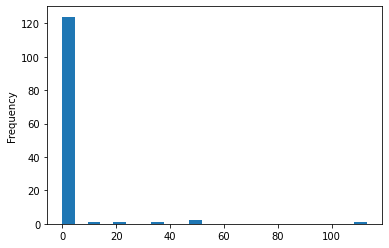

In [9]:
org.iloc[:, 0].plot.hist(bins=24, alpha=1).get_figure().savefig('org_count.png')

In [10]:
trans = transform_features(org, transformation="mclr")

<ipython-input-4-f3d0c3d7d389>:13: RuntimeWarning: invalid value encountered in log
  Z = np.log(X_pos / g)


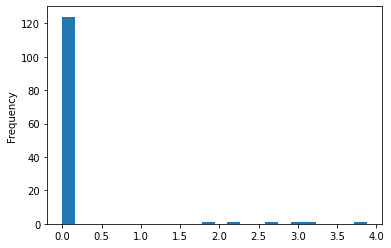

In [11]:
trans.iloc[:, 0].plot.hist(bins=24, alpha=1).get_figure().savefig('mclr_count.png')

In [12]:
# clr-transformed Atacama soil microbiome
# acm = pd.read_csv('~/GGLasso/data/soil/processed/acm_clr.tsv', sep='\t', index_col = 0)

# mclr-transformed Atacama soil microbiome
# acm = pd.read_csv('~/q2-gglasso/data/atacama-table_mclr_small/small_mclr_feature-table.tsv', sep='\t', index_col = 0)

acm = trans
acm

# (p, N)
acm.shape

(130, 53)

In [13]:
acm

BAQ2420.1.1  BAQ2420.1.2  BAQ2420.1.3  \
#OTU ID                                                                   
409faa5f5353e543bf6d99125c7c0e83          0.0     0.000000     0.000000   
1237d5925a7176fced9dda961a86c684          0.0     0.000000     1.250439   
a7b877ae6d2f079a15b6b192a4425620          0.0     0.000000     0.000000   
ef3fdbe1dcde754d91130cde6a4b4d61          0.0     2.668353     0.000000   
96cbccca68ad868a78bb0604e4a41cf5          0.0     0.000000     0.000000   
...                                       ...          ...          ...   
f31d6dfeec66b22ac98f0605d57e7bb4          0.0     0.000000     0.000000   
9c52587208449196032dd3b5417a0726          0.0     0.000000     0.000000   
d77495f5ee973c882fee45fc5fbf77a5          0.0     0.000000     0.000000   
e4b8e17d0dbcb08f2ef6d45d4e291493          0.0     2.014427     0.000000   
f9c93ccfdaccc1f8111dea02735ff80a          0.0     0.000000     0.000000   

                                  BAQ2420.2  BAQ2420.3  BAQ2462.1  BAQ2462.2  \
#OTU ID                                                                        
409faa5f5353e543bf6d99125c7c0e83   0.000000   0.000000   0.000000   0.000000   
1237d5925a7176fced9dda961a86c684   3.858251   0.000000   3.392946   2.890503   
a7b877ae6d2f079a15b6b192a4425620   3.025342   3.158820   2.767240   2.025505   
ef3fdbe1dcde754d91130cde6a4b4d61   0.000000   0.000000   0.000000   0.000000   
96cbccca68ad868a78bb0604e4a41cf5   0.000000   0.000000   0.000000   0.000000   
...                                     ...        ...        ...        ...   
f31d6dfeec66b22ac98f0605d57e7bb4   3.228283   2.830316   1.883038   0.000000   
9c52587208449196032dd3b5417a0726   0.000000   0.000000   0.000000   0.000000   
d77495f5ee973c882fee45fc5fbf77a5   0.000000   0.000000   0.000000   0.000000   
e4b8e17d0dbcb08f2ef6d45d4e291493   1.821369   0.000000   0.000000   0.000000   
f9c93ccfdaccc1f8111dea02735ff80a   0.000000   0.000000   0.000000   0.000000   

                                  BAQ2462.3  BAQ2687.1  BAQ2687.2  ...  \
#OTU ID                                                            ...   
409faa5f5353e543bf6d99125c7c0e83   0.000000   0.000000        0.0  ...   
1237d5925a7176fced9dda961a86c684   0.000000   0.000000        0.0  ...   
a7b877ae6d2f079a15b6b192a4425620   3.586397   0.000000        0.0  ...   
ef3fdbe1dcde754d91130cde6a4b4d61   0.000000   0.000000        0.0  ...   
96cbccca68ad868a78bb0604e4a41cf5   0.000000   0.000000        0.0  ...   
...                                     ...        ...        ...  ...   
f31d6dfeec66b22ac98f0605d57e7bb4   0.000000   0.000000        0.0  ...   
9c52587208449196032dd3b5417a0726   0.000000   2.794737        0.0  ...   
d77495f5ee973c882fee45fc5fbf77a5   0.000000   0.000000        0.0  ...   
e4b8e17d0dbcb08f2ef6d45d4e291493   0.000000   0.000000        0.0  ...   
f9c93ccfdaccc1f8111dea02735ff80a   0.000000   2.977059        0.0  ...   

                                  YUN3533.1.1  YUN3533.1.2  YUN3533.1.3  \
#OTU ID                                                                   
409faa5f5353e543bf6d99125c7c0e83          0.0     3.868369     4.724359   
1237d5925a7176fced9dda961a86c684          0.0     0.000000     3.856596   
a7b877ae6d2f079a15b6b192a4425620          0.0     0.000000     0.000000   
ef3fdbe1dcde754d91130cde6a4b4d61          0.0     0.000000     3.310052   
96cbccca68ad868a78bb0604e4a41cf5          0.0     2.906958     3.052223   
...                                       ...          ...          ...   
f31d6dfeec66b22ac98f0605d57e7bb4          0.0     0.000000     0.000000   
9c52587208449196032dd3b5417a0726          0.0     0.000000     0.000000   
d77495f5ee973c882fee45fc5fbf77a5          0.0     0.000000     0.000000   
e4b8e17d0dbcb08f2ef6d45d4e291493          0.0     0.000000     1.605304   
f9c93ccfdaccc1f8111dea02735ff80a          0.0     0.000000     0.000000   

                                  YUN3533.2  YUN3533.3  YUN3856.1.1  \
#OTU ID

array([<AxesSubplot:title={'center':'BAQ2420.1.1'}>,
       <AxesSubplot:title={'center':'BAQ2420.1.2'}>,
       <AxesSubplot:title={'center':'BAQ2420.1.3'}>,
       <AxesSubplot:title={'center':'BAQ2420.2'}>,
       <AxesSubplot:title={'center':'BAQ2420.3'}>,
       <AxesSubplot:title={'center':'BAQ2462.1'}>,
       <AxesSubplot:title={'center':'BAQ2462.2'}>,
       <AxesSubplot:title={'center':'BAQ2462.3'}>,
       <AxesSubplot:title={'center':'BAQ2687.1'}>,
       <AxesSubplot:title={'center':'BAQ2687.2'}>,
       <AxesSubplot:title={'center':'BAQ2687.3'}>,
       <AxesSubplot:title={'center':'BAQ2838.1'}>,
       <AxesSubplot:title={'center':'BAQ2838.2'}>,
       <AxesSubplot:title={'center':'BAQ2838.3'}>,
       <AxesSubplot:title={'center':'BAQ3473.1'}>,
       <AxesSubplot:title={'center':'BAQ3473.2'}>,
       <AxesSubplot:title={'center':'BAQ3473.3'}>,
       <AxesSubplot:title={'center':'BAQ4166.1.1'}>,
       <AxesSubplot:title={'center':'BAQ4166.1.2'}>,
       <AxesSubplot:t

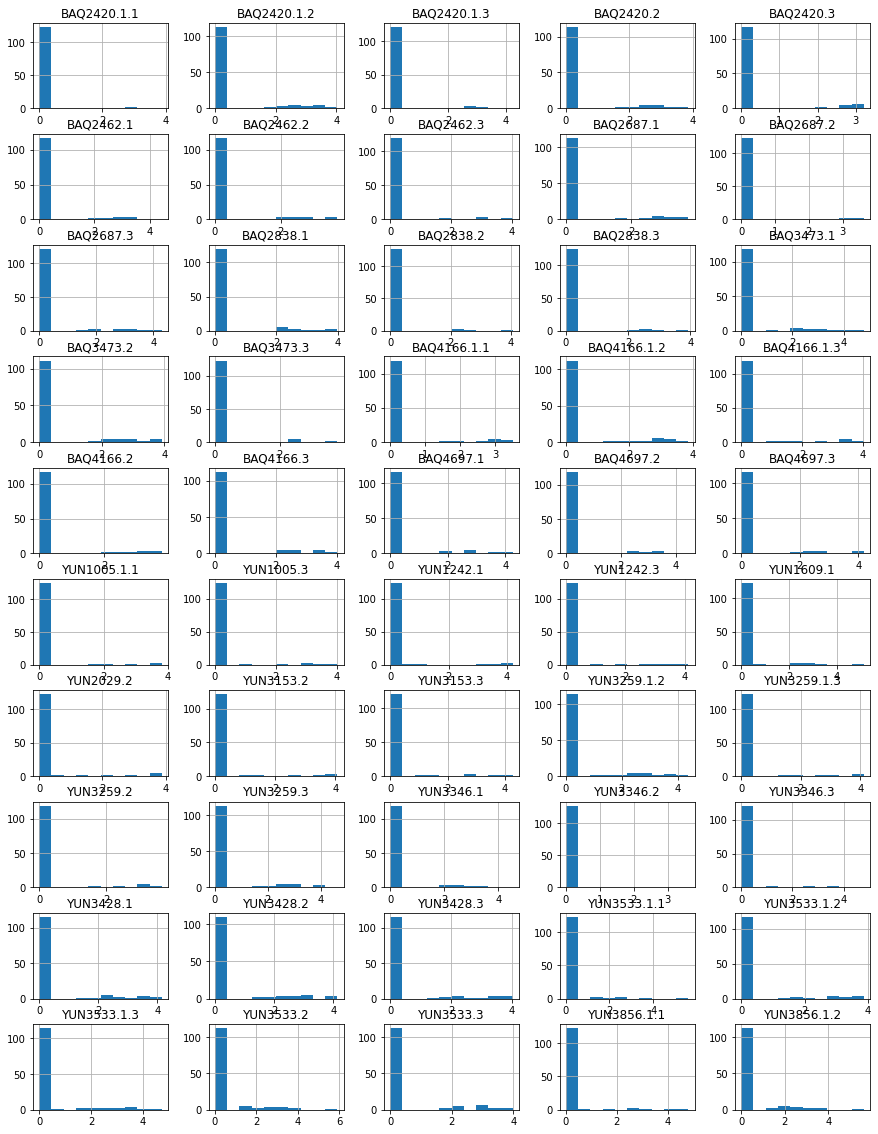

In [14]:
fig, axis = plt.subplots(10, 5,figsize=(15, 20))
acm.iloc[:, :-3].hist(ax=axis)
# fig = axis.get_figure()
# fig.savefig('meta_hist_scaled.png')

In [15]:
# covariates
meta = pd.read_csv('~/GGLasso/data/soil/processed/acm_meta.tsv', sep='\t', index_col = 0)

meta = meta.loc[:, meta.iloc[0, :] != 'categorical']
meta = meta.apply(pd.to_numeric, errors='coerce')
meta = meta.dropna(how='all')
meta = meta.iloc[1:]

print(meta.shape)

meta.head()

(74, 15)


elevation  extract-concen  amplicon-concentration  depth    ph  \
sample-id                                                                     
BAQ1370.3       1370.0           0.124                   17.46    2.0   NaN   
BAQ1370.1.3     1370.0           1.200                    0.96    3.0  8.13   
BAQ1552.1.1     1552.0           0.722                   18.83    1.0  7.87   
BAQ1552.2       1552.0           0.017                    2.00    2.0   NaN   
BAQ2420.1.1     2420.0           0.350                    7.40    1.0  9.33   

               toc     ec  average-soil-relative-humidity  \
sample-id                                                   
BAQ1370.3    771.0  6.080                           16.17   
BAQ1370.1.3    NaN    NaN                           16.17   
BAQ1552.1.1    NaN    NaN                           15.75   
BAQ1552.2    223.0  1.839                           15.75   
BAQ2420.1.1    NaN    NaN                           82.54   

             relative-humidity-soil-high  relative-humidity-soil-low  \
sample-id                                                              
BAQ1370.3                          23.97                      11.420   
BAQ1370.1.3                        23.97                      11.420   
BAQ1552.1.1                        35.36                      11.100   
BAQ1552.2                          35.36                      11.100   
BAQ2420.1.1                       100.00                      41.135   

             percent-relative-humidity-soil-100  average-soil-temperature  \
sample-id                                                                   
BAQ1370.3                                  0.00                     22.61   
BAQ1370.1.3                                0.00                     22.61   
BAQ1552.1.1                                0.00                     22.63   
BAQ1552.2                                  0.00                     22.63   
BAQ2420.1.1                               46.77                     22.45   

             temperature-soil-high  temperature-soil-low  percentcover  
sample-id                                                               
BAQ1370.3                   35.210                12.460           0.0  
BAQ1370.1.3                 35.210                12.460           0.0  
BAQ1552.1.1                 30.650                10.960           0.0  
BAQ1552.2                   30.650                10.960           0.0  
BAQ2420.1.1                 28.297                13.294           0.0

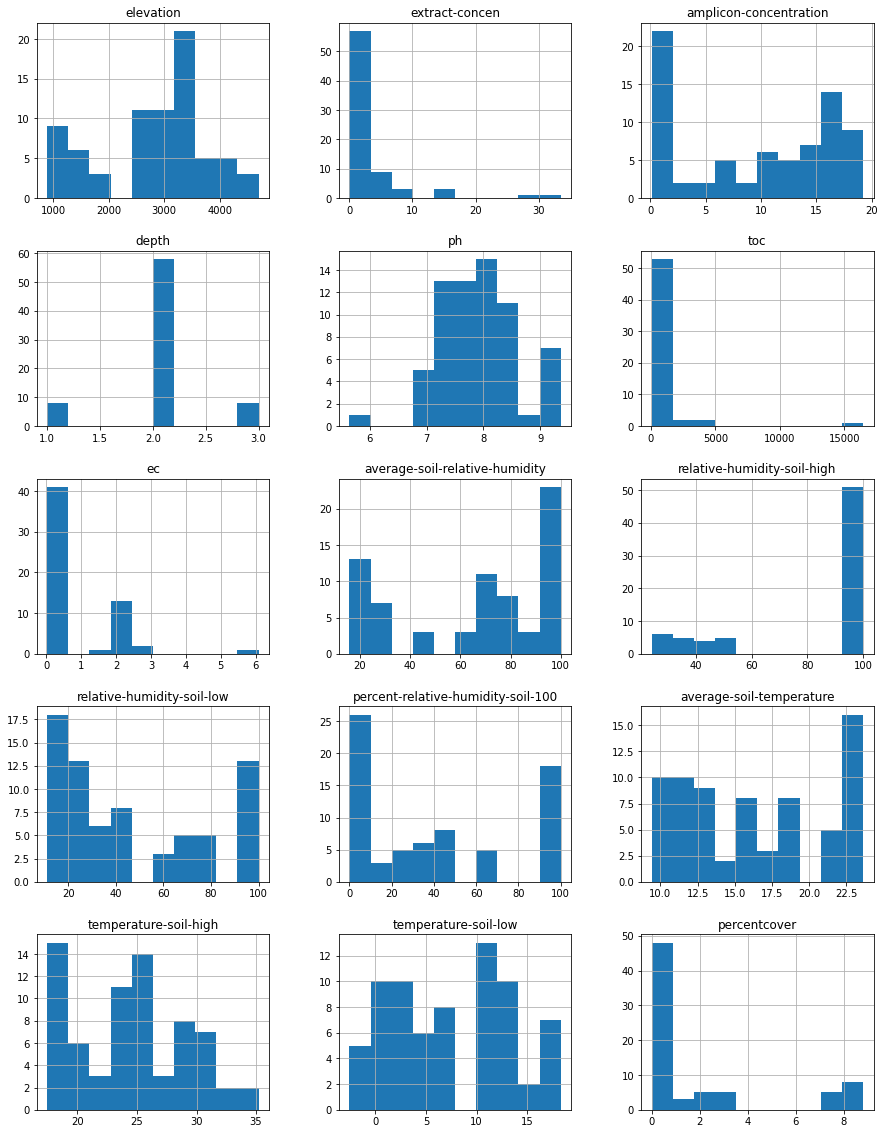

In [16]:
fig, axis = plt.subplots(5,3,figsize=(15, 20))
meta.hist(ax=axis)
# fig = axis.get_figure()
fig.savefig('meta_hist.png')

### Standartization

In [17]:
from sklearn import preprocessing

In [18]:
scaler = preprocessing.StandardScaler().fit(meta)

In [19]:
scaler.mean_

array([2.84479730e+03, 2.96786486e+00, 9.65432432e+00, 2.00000000e+00,
       7.89272727e+00, 8.88103448e+02, 8.27793103e-01, 6.66040845e+01,
       8.25998873e+01, 4.59172113e+01, 3.99978873e+01, 1.62901408e+01,
       2.44466479e+01, 7.47126761e+00, 1.84635135e+00])

In [20]:
scaler.scale_

array([9.99828945e+02, 5.94665380e+00, 6.73271984e+00, 4.64990555e-01,
       6.70066811e-01, 2.17318977e+03, 1.17694188e+00, 3.10046312e+01,
       2.74684014e+01, 3.17190535e+01, 3.92001048e+01, 4.85577846e+00,
       4.72702099e+00, 5.85880610e+00, 3.03834351e+00])

In [21]:
meta_scaled = scaler.transform(meta)

In [22]:
meta_scaled.mean(axis=0)

array([-2.04040988e-16,  2.05822596e-17, -2.40048222e-17,  0.00000000e+00,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  8.55171789e-17])

In [23]:
meta_scaled.std(axis=0)

array([ 1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1.])

In [24]:
meta_scaled = pd.DataFrame(meta_scaled, index=meta.index, columns=meta.columns)
meta_scaled.head()

elevation  extract-concen  amplicon-concentration     depth  \
sample-id                                                                  
BAQ1370.3    -1.475050       -0.478229                1.159364  0.000000   
BAQ1370.1.3  -1.475050       -0.297287               -1.291354  2.150581   
BAQ1552.1.1  -1.293018       -0.377669                1.362848 -2.150581   
BAQ1552.2    -1.293018       -0.496223               -1.136884  0.000000   
BAQ2420.1.1  -0.424870       -0.440225               -0.334831 -2.150581   

                   ph       toc        ec  average-soil-relative-humidity  \
sample-id                                                                   
BAQ1370.3         NaN -0.053886  4.462588                       -1.626663   
BAQ1370.1.3  0.354103       NaN       NaN                       -1.626663   
BAQ1552.1.1 -0.033918       NaN       NaN                       -1.640209   
BAQ1552.2         NaN -0.306049  0.859182                       -1.640209   
BAQ2420.1.1  2.144969       NaN       NaN                        0.513985   

             relative-humidity-soil-high  relative-humidity-soil-low  \
sample-id                                                              
BAQ1370.3                      -2.134448                   -1.087586   
BAQ1370.1.3                    -2.134448                   -1.087586   
BAQ1552.1.1                    -1.719790                   -1.097675   
BAQ1552.2                      -1.719790                   -1.097675   
BAQ2420.1.1                     0.633459                   -0.150768   

             percent-relative-humidity-soil-100  average-soil-temperature  \
sample-id                                                                   
BAQ1370.3                             -1.020352                  1.301513   
BAQ1370.1.3                           -1.020352                  1.301513   
BAQ1552.1.1                           -1.020352                  1.305632   
BAQ1552.2                             -1.020352                  1.305632   
BAQ2420.1.1                            0.172758                  1.268563   

             temperature-soil-high  temperature-soil-low  percentcover  
sample-id                                                               
BAQ1370.3                 2.276984              0.851493     -0.607684  
BAQ1370.1.3               2.276984              0.851493     -0.607684  
BAQ1552.1.1               1.312317              0.595468     -0.607684  
BAQ1552.2                 1.312317              0.595468     -0.607684  
BAQ2420.1.1               0.814541              0.993843     -0.607684

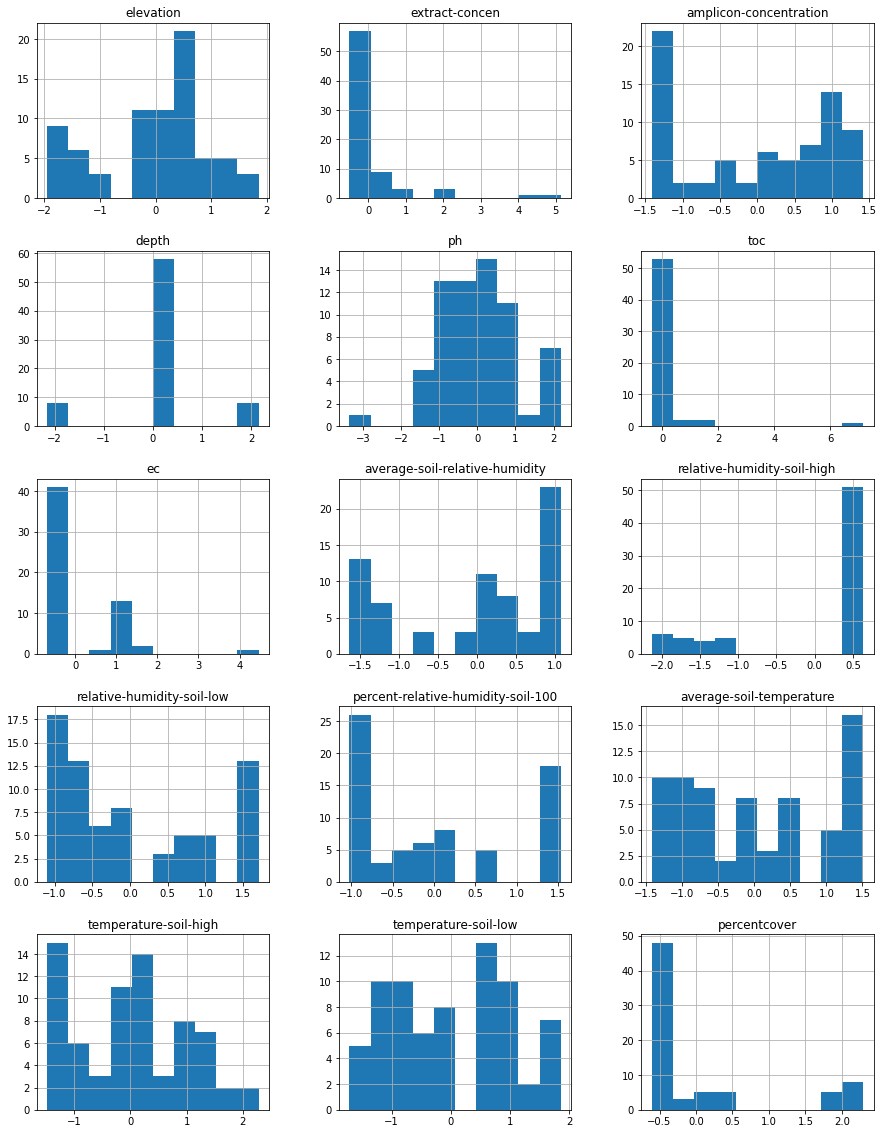

In [25]:
fig, axis = plt.subplots(5,3,figsize=(15, 20))
meta_scaled.hist(ax=axis)
# fig = axis.get_figure()
fig.savefig('meta_hist_scaled.png')

In [26]:
meta_scaled.shape

(74, 15)

### !!! We transpose count table to be able to merge with covariates

In [27]:
get_tps(meta_scaled)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.


array(['con', 'con', 'con', 'ter', 'con', 'con', 'con', 'con', 'con',
       'con', 'con', 'con', 'con', 'con', 'con'], dtype='<U3')

In [28]:
# join by sample id

acm_T = acm.T

df = acm_T.join(meta_scaled)

# #drop missing values
# df = df.dropna(how='any')

df.isnull().sum().any()

True

We will missing covariates with 0

In [29]:
df = df.fillna(0)

In [30]:
df.isnull().sum().any()

False

In [31]:
df.shape

(53, 145)

In [32]:
acm_T.shape, meta_scaled.shape

((53, 130), (74, 15))

In [34]:
df.shape

(53, 145)

In [35]:
# drop covariates with zero variance
for var in df.columns:
    if df[var].var() == 0:
        print("'{0}' covariate has been dropped".format(var))
        del df[var]
# (df.var() == 0)
# print(df.var().to_string())

In [36]:
df.shape

(53, 145)

### Check sparsity level of each feature and covariate

In [66]:
sp_df = pd.DataFrame(df.astype(bool).sum(axis=0), columns=["sp_level"])
non_sparse_features = sp_df[sp_df["sp_level"] > 5].index


df = df[df.columns & non_sparse_features]

In [44]:
# df.iloc[:, :-14].shape

### Latent correlation

In [67]:
N, p = df.shape

# clean_types = get_tps(df)
clean_types = get_tps(df)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by eith

In [68]:
df.shape

(53, 52)

In [69]:
clean_types

array(['tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'con', 'con', 'con', 'ter', 'con', 'con', 'con', 'con',
       'con', 'con', 'con', 'con', 'con', 'con', 'con'], dtype='<U3')

In [112]:
# a = ["tru"]*130 + ["con"]*15

In [70]:
clean_types

array(['tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru', 'tru',
       'tru', 'con', 'con', 'con', 'ter', 'con', 'con', 'con', 'con',
       'con', 'con', 'con', 'con', 'con', 'con', 'con'], dtype='<U3')

In [71]:
# vis_df = df.copy()
vis_df = df.copy()

In [72]:
vis_df.isna().any().sum()

0

In [73]:
vis_df.shape

(53, 52)

In [74]:
# Rename long feature IDs with concise names
id_dict = dict()

i = 1
for col in vis_df.columns:
    # length of ASVs identifier
    if len(col) == 32:
        asv_name = "ASV_{0}".format(i)
        id_dict[asv_name] = col
        vis_df.rename(columns={col: asv_name}, inplace=True)
        
        i += 1

In [77]:
# corr_ = vis_df.corr(method='kendall')
# doff = corr_ - S_org
# np.linalg.eigvalsh(corr_)

# fig = px.imshow(corr_, color_continuous_scale='RdBu_r')
# fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
#                  title='Kendall', title_x=0.5)


# lat_cor_1 = latentcor(vis_df, tps=clean_types, method='approx', use_nearPD=False)

# lat_cor_1.keys()
# S_1 = lat_cor_1['Rpointwise']
# np.linalg.eigvalsh(S_1)

In [79]:
### N, p input
lat_cor = latentcor(vis_df, tps=clean_types, method='original', use_nearPD=False)
# lat_cor = latentcor(vis_df, tps=clean_types, method='approx', use_nearPD=True, nu=0.001, tol=1e-4)
# lat_cor = latentcor(vis_df, tps=clean_types, method='approx')

In [80]:
lat_cor.keys()

dict_keys(['R', 'Rpointwise', 'plot', 'K', 'zratios'])

In [81]:
S_org = lat_cor['R']

In [82]:
np.linalg.eigvalsh(S_org)

array([-7.7836714e+00, -2.8193469e+00, -1.8854485e+00, -1.7514886e+00,
       -1.6340810e+00, -1.4130317e+00, -1.2272831e+00, -1.1515899e+00,
       -1.0092502e+00, -9.1787159e-01, -8.5185242e-01, -6.3192743e-01,
       -4.9491671e-01, -4.6136025e-01, -3.3880699e-01, -2.0715186e-01,
       -1.4866859e-01, -1.1304250e-01, -8.2905225e-02, -5.1644858e-02,
       -1.7295852e-02, -2.6913115e-03,  1.3155368e-02,  1.8016774e-02,
        4.8179593e-02,  1.1000103e-01,  1.1720648e-01,  1.3504221e-01,
        2.3570390e-01,  2.9798347e-01,  3.6642537e-01,  4.6102345e-01,
        5.5391598e-01,  5.5853927e-01,  6.9973022e-01,  8.2134897e-01,
        9.1040510e-01,  1.1005470e+00,  1.3576981e+00,  1.3697189e+00,
        1.4619726e+00,  2.1327863e+00,  2.3794031e+00,  2.9582398e+00,
        3.2939210e+00,  3.9878609e+00,  4.4675264e+00,  4.6770864e+00,
        5.2427230e+00,  6.7435126e+00,  9.5208693e+00,  2.0954786e+01],
      dtype=float32)

In [151]:
S = lat_cor['R']

In [152]:
np.linalg.eigvalsh(S)

array([1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
      

In [76]:
S_1 = lat_cor['Rpointwise']

In [85]:
lat_cor['zratios']

array([[0.725, 0.875, 0.7  , 0.575, 0.9  , 0.75 , 0.925, 0.775, 0.875,
        0.8  , 0.7  , 0.5  , 0.7  , 0.825, 0.9  , 0.875, 0.65 , 0.775,
        0.925, 0.925, 0.875, 0.975, 0.875, 0.975, 0.975, 0.925, 0.925,
        0.875, 0.875, 0.9  , 0.9  , 0.875, 0.825, 0.675, 0.975, 0.975,
        0.925, 0.9  , 0.875, 0.975, 0.85 , 0.95 , 0.625, 0.9  , 0.975,
        0.9  , 0.95 , 0.875, 0.75 , 0.975, 0.975, 0.95 , 0.9  , 0.925,
        0.925, 0.975, 0.95 , 0.925, 0.9  , 0.925, 0.9  , 0.925, 0.975,
        0.825, 0.95 , 0.95 , 0.9  , 0.95 , 0.9  , 0.975, 0.95 , 0.95 ,
        0.925, 0.925, 0.85 , 0.875, 0.975, 0.975, 0.8  , 0.975, 0.9  ,
        0.925, 0.975, 0.775, 0.975, 0.95 , 0.925, 0.9  , 0.925, 0.925,
        0.925, 0.975, 0.925, 0.95 , 0.9  , 0.95 , 0.95 , 0.975, 0.925,
        0.9  , 0.95 , 0.9  , 0.925, 0.975, 0.975, 0.9  , 0.925, 0.9  ,
        0.95 , 0.95 , 0.95 , 0.9  , 0.925, 0.975, 0.975, 0.925, 0.95 ,
        0.95 , 0.825, 0.975,   nan,   nan,   nan,   nan,   nan,   nan,
      

In [74]:
lat_cor.keys()

dict_keys(['R', 'Rpointwise', 'plot', 'K', 'zratios'])

In [75]:
lat_cor

{'R':                                        ASV_1     ASV_2     ASV_3     ASV_4  \
 ASV_1                               1.000000  0.249591 -0.929421  0.313647   
 ASV_2                               0.249591  1.000000  0.501806 -0.915386   
 ASV_3                              -0.929421  0.501806  1.000000 -0.193397   
 ASV_4                               0.313647 -0.915386 -0.193397  1.000000   
 ASV_5                               0.717933  0.717762 -0.762069 -0.217807   
 ...                                      ...       ...       ...       ...   
 percent-relative-humidity-soil-100  0.574382  0.157436 -0.491895  0.191649   
 average-soil-temperature           -0.700900  0.157436  0.741128 -0.344696   
 temperature-soil-high              -0.723037  0.266194  0.730887 -0.364279   
 temperature-soil-low               -0.717503  0.124858  0.771213 -0.300635   
 percentcover                        0.638473 -0.032570 -0.660439  0.204168   
 
                                        ASV_5

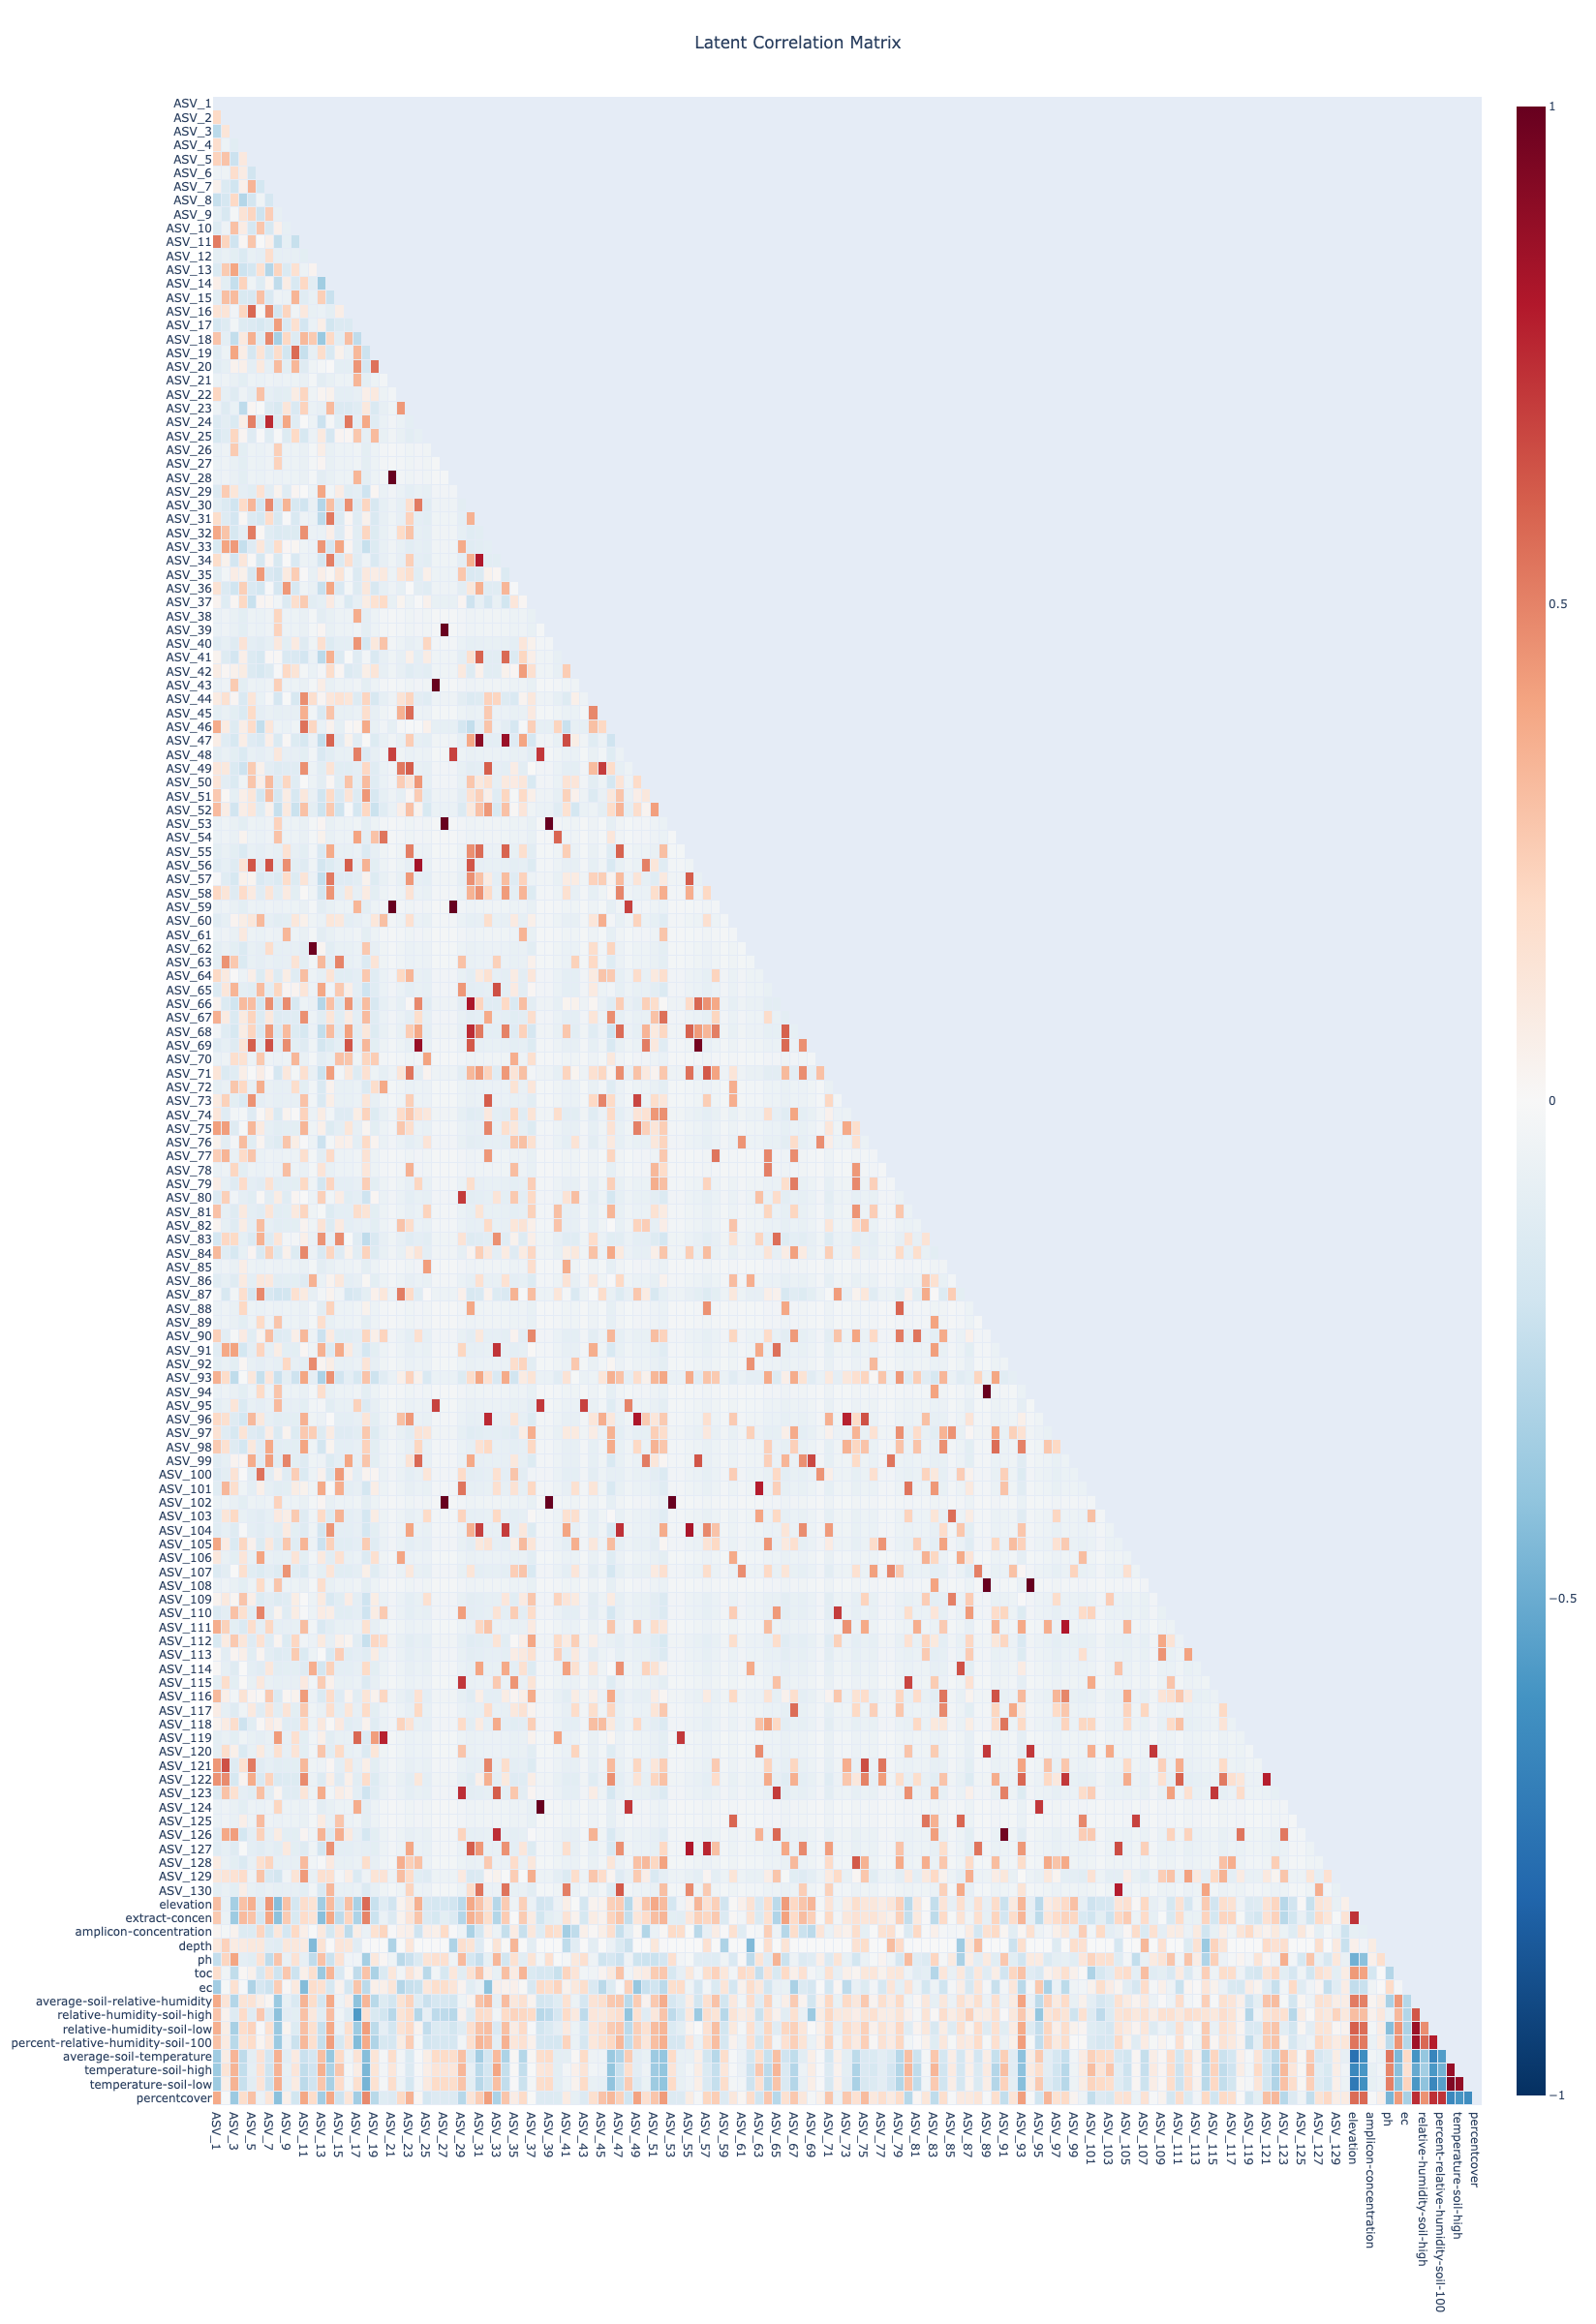

In [167]:
mask = np.triu(np.ones_like(S, dtype=bool))
rLT = S.mask(mask)
# rLT = corr_.mask(mask)

heat = go.Heatmap(
    z = rLT,
    x = rLT.columns.values,
    y = rLT.columns.values,
    zmin = - 1, # Sets the lower bound of the color domain
    zmax = 1,
    xgap = 1, # Sets the horizontal gap (in pixels) between bricks
    ygap = 1,
    colorscale = 'RdBu_r'
)

title = 'Latent Correlation Matrix'

layout = go.Layout(
    title_text=title, 
    title_x=0.5, 
    width=2400, 
    height=2400,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig=go.Figure(data=[heat], layout=layout)
fig.show()

# fig.write_image("../plots/png/latent_corr.png")
# fig.write_html("../plots/html/latent_corr.html")

In [70]:
meta_ticks = np.array(S.columns[-14:])
bug_ticks = np.arange(len(S.columns[:-14]))
ticks = np.hstack((bug_ticks, meta_ticks))

In [71]:
S.to_csv("/Users/oleg.vlasovetc/Desktop/acm_latent_corr.csv", index=False)

In [77]:
np.linalg.eigvalsh(S_1)

array([-4.22346420e+01, -8.08416176e+00, -5.67577982e+00, -4.93324327e+00,
       -4.56659603e+00, -4.36481380e+00, -4.21305084e+00, -4.05248785e+00,
       -3.81480670e+00, -3.66880059e+00, -3.42831111e+00, -3.33620024e+00,
       -3.32670355e+00, -3.15628242e+00, -3.09772873e+00, -2.95785308e+00,
       -2.92155337e+00, -2.77966595e+00, -2.62102890e+00, -2.56238437e+00,
       -2.50536180e+00, -2.46161556e+00, -2.38247609e+00, -2.30408239e+00,
       -2.24846339e+00, -2.15184546e+00, -2.10675168e+00, -2.08558488e+00,
       -1.91646409e+00, -1.85616624e+00, -1.82472074e+00, -1.79231846e+00,
       -1.70502245e+00, -1.63900685e+00, -1.58605480e+00, -1.52862012e+00,
       -1.46126199e+00, -1.44047558e+00, -1.36134124e+00, -1.29591179e+00,
       -1.22918046e+00, -1.17282498e+00, -1.07863975e+00, -1.02590835e+00,
       -1.00510275e+00, -9.20577526e-01, -8.69797051e-01, -7.99280345e-01,
       -7.55663991e-01, -7.23788857e-01, -6.87908888e-01, -6.47637069e-01,
       -6.26222193e-01, -

### Just covariance

In [141]:
df.shape

N = df.shape[0]
p = df.shape[1]

In [142]:
S = np.cov(df.T.values, bias=True)
S.shape

(52, 52)

In [125]:
# S = scale_array_by_diagonal(S)

In [143]:
S = pd.DataFrame(S, index=df.columns, columns=df.columns)
S

409faa5f5353e543bf6d99125c7c0e83  \
409faa5f5353e543bf6d99125c7c0e83                            2.527354   
1237d5925a7176fced9dda961a86c684                            0.564464   
a7b877ae6d2f079a15b6b192a4425620                           -0.605421   
ef3fdbe1dcde754d91130cde6a4b4d61                            0.451655   
96cbccca68ad868a78bb0604e4a41cf5                            0.455307   
11f7b172e09b77715d3bb2175a40b409                           -0.046040   
1694836fc379411d2b9aa087d68d571b                            0.158264   
a36b38f754f6abd278aeb9dbc7696343                           -0.446695   
ffd60d684f32e6fd5b47fe90095f9d34                           -0.192631   
c6a6705874a49360a01c2b3fd39fe900                           -0.309142   
f6c10a04d57159c0d64d6bc30c677471                            1.389584   
dc8a2f47b3d1dc2e1f5f805891976b29                           -0.292020   
5c78314ff92e6fec9aa07acc1fa0dc24                            0.024641   
ddbc32632c9632d1dd746f28721f3a9f                           -0.254101   
352875c83f4adf659984d683666d2038                            0.248149   
6e4d034e4b967b745639f825dc73ebe6                           -0.261844   
6b780e361cfc5f06def718518324bdcb                            0.516780   
5eee6273221f15d4e0cdc2c033f0dd72                           -0.216568   
f2e9c4d09183997ce7cdab5a93686b4c                           -0.093336   
8d0ef18ec87e81bbb286975b9b0cb5b6                           -0.207650   
0013c1743927ee19a962b903b8990896                            0.140298   
dbaaec51eeca49cb19d683ec4ed2ea7a                            0.223502   
82bd79dc4db9e3681c376c90b1604fa8                           -0.190586   
9b93b0042b0a3fba92a57224122cea67                            0.134166   
a56b903521b8ab33a7878b35582803a8                            0.169618   
f922bb836523db0b8e265a464de54690                           -0.054056   
fad7959733a200344fe5a2a9f6252f81                            0.078187   
6898520892f36d2f9597b1c708e294f0                            0.144496   
cdb9c0ee3bba4c3d8b9292eb575bd9e3                            0.645781   
eaafa5ddaa83a001babed4208f4817c6                            0.311160   
4c8ff0ea98d2c0ebb486e33bd96c61f9                            0.408424   
88d17d59e9681436cc60ba2ef049d35d                            0.042068   
24e9c725863735bd49ea92bbfd06ff22                            0.147721   
b81d437663f6fa47595d54669713c504                           -0.191410   
36d3b99cbc044e1531dc21fb94159f72                           -0.052612   
89cb1ddf89dcf11d86f725dbcaa9a5ce                            0.348707   
e4b8e17d0dbcb08f2ef6d45d4e291493                            0.140196   
elevation                                                   0.396551   
extract-concen                                              0.138712   
amplicon-concentration                                      0.133170   
depth                                                       0.191700   
ph                                                         -0.387523   
toc                                                        -0.070242   
ec                                                         -0.212088   
average-soil-relative-humidity                              0.496057   
relative-humidity-soil-high                                 0.243573   
relative-humidity-soil-low                                  0.668525   
percent-relative-humidity-soil-100                          0.622246   
average-soil-temperature                                   -0.659382   
temperature-soil-high                                      -0.544562   
temperature-soil-low                                       -0.573223   
percentcover                                                0.703460   

                                    1237d5925a7176fced9dda961a86c684  \
409faa5f5353e543bf6d99125c7c0e83                            0.564464   
1237d5925a7176fced9dda961a86c684                            1.643138   
a7b

### SGL: species and covariates together

In [127]:
P_SGL = glasso_problem(S.values, N, latent=False, do_scaling=False)
print(P_SGL)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [128]:
lambda1_range = np.logspace(0, -2.5, 50)

modelselect_params = {'lambda1_range': lambda1_range}

In [129]:
lambda1_range

array([1.        , 0.88915933, 0.79060432, 0.70297321, 0.62505519,
       0.55577366, 0.49417134, 0.43939706, 0.39069399, 0.34738921,
       0.30888436, 0.27464741, 0.24420531, 0.21713743, 0.19306977,
       0.17166979, 0.1526418 , 0.13572288, 0.12067926, 0.10730309,
       0.09540955, 0.08483429, 0.0754312 , 0.06707036, 0.05963623,
       0.05302611, 0.04714866, 0.04192267, 0.03727594, 0.03314425,
       0.02947052, 0.02620399, 0.02329952, 0.02071698, 0.0184207 ,
       0.01637894, 0.01456348, 0.01294926, 0.01151395, 0.01023774,
       0.00910298, 0.008094  , 0.00719686, 0.00639915, 0.00568987,
       0.0050592 , 0.00449843, 0.00399982, 0.00355648, 0.00316228])

In [130]:
P_SGL.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1)
print(P_SGL.reg_params)

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated

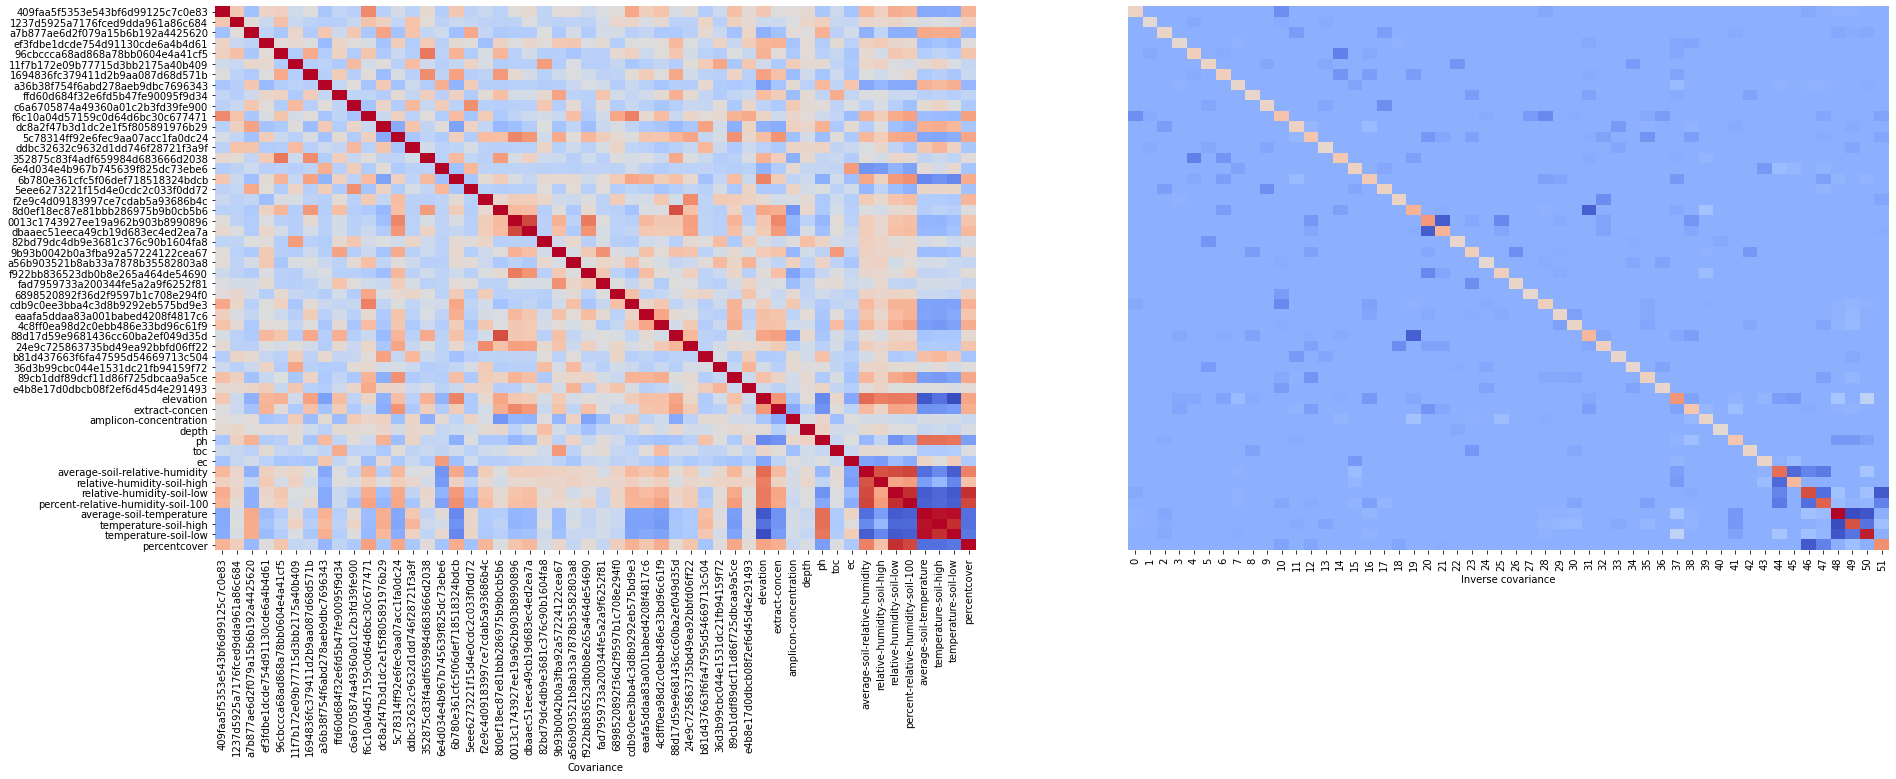

In [131]:
covariance = pd.DataFrame(S)
precision = pd.DataFrame(P_SGL.solution.precision_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(covariance, cmap='coolwarm', cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('Covariance')

g2 = sns.heatmap(precision, cmap='coolwarm', cbar=False, ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('Inverse covariance')
g2.set_yticks([])

for ax in [g1, g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()
# plt.savefig("../plots/png/SGL_solution.png")

In [111]:
P_SGL.modelselect_stats

{'BIC': {0.1: array([[2720.83028819],
         [2723.26731734],
         [2719.39226596],
         [2692.63437301],
         [2706.87225203],
         [2685.36923928],
         [2682.84953906],
         [2676.8267024 ],
         [2654.64961423],
         [2651.86315648],
         [2640.25472705],
         [2625.20807145],
         [2682.61097038],
         [2728.47592431],
         [2770.20265011],
         [2832.04726265],
         [2906.03716037],
         [3024.77129588],
         [3142.82659329],
         [3204.34722181],
         [3360.79250052],
         [3440.40872854],
         [3494.2044874 ],
         [3549.88807479],
         [3597.19727842],
         [3663.69568526],
         [3765.26154163],
         [3812.50634907],
         [3900.79507165],
         [3930.79994046],
         [3997.29551357],
         [4180.99444119],
         [4276.35789207],
         [4346.48070803],
         [4406.44836925],
         [4517.30835314],
         [4618.86704078],
         [4683.24137659],


### SGL + low-rank: species and covariates together

In [96]:
P_SGL_L = glasso_problem(S, N, latent=True, do_scaling=False)
print(P_SGL_L)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [97]:
lambda1_range = [0.5]
mu1_range = [15, 10, 5, 3.7, 3, 2.25, 2.1, 2, 1.7, 1.6]

# lambda1_range = [0.05, 0.025, 0.01]
# mu1_range = [5, 3.7, 3, 2.25, 2.1, 2, 1.7, 1.6]

modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

In [98]:
P_SGL_L.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)
print(P_SGL_L.reg_params)

ADMM terminated after 89 iterations with status: optimal.
ADMM terminated after 66 iterations with status: optimal.
ADMM terminated after 55 iterations with status: optimal.
ADMM terminated after 50 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 52 iterations with status: optimal.
ADMM terminated after 52 iterations with status: optimal.
{'lambda1': 0.5, 'mu1': 5.0}


In [99]:
P_SGL_L.modelselect_stats

{'BIC': {0.1: array([[2652.82712407, 2646.68378683, 2737.58406234, 2812.1498294 ,
          2854.74247452, 2964.29743071, 2992.00527211, 3014.09152464,
          3105.18814277, 3138.02805511]]),
  0.5: array([[3183.87427985, 3146.12099286, 2901.95580103, 2906.97967864,
          2917.96237402, 3002.22937041, 3023.61522186, 3039.37948443,
          3124.15411262, 3150.67203501]]),
  0.3: array([[2918.35070196, 2896.40238984, 2819.76993168, 2859.56475402,
          2886.35242427, 2983.26340056, 3007.81024699, 3026.73550454,
          3114.6711277 , 3144.35004506]]),
  0.25: array([[2851.96980749, 2833.97273909, 2799.22346435, 2847.71102287,
          2878.44993683, 2978.5219081 , 3003.85900327, 3023.57450956,
          3112.30038147, 3142.76954758]]),
  0.7: array([[3449.39785774, 3395.83959587, 2984.14167038, 2954.39460327,
          2949.57232377, 3021.19534026, 3039.42019674, 3052.02346433,
          3133.63709755, 3156.99402496]])},
 'AIC': array([[2270.56081439, 2287.17142415, 2619.

In [158]:
Theta_SGL_L = P_SGL_L.solution.precision_

In [159]:
L = P_SGL_L.solution.lowrank_

In [160]:
l_names = list()

for i in range(1, L.shape[0]+1):
    l_names.append("L{0}".format(i))

In [161]:
a = pd.DataFrame(L, columns=l_names)
b = S.reset_index(drop=True) 
c = pd.concat([a, b], axis=1)

In [162]:
test = pd.concat([c.iloc[:, 0:2], c.iloc[:, -2:]], axis=1)

In [163]:
fig = px.scatter_matrix(test, title="Scatter matrix of low-rank vs. correlation vectors")
fig.update_traces(diagonal_visible=False)

fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Low-rank vectors vs. Correlation vectors between the covariates and ASVs', title_x=0.5)


fig.write_image("../plots/png/scatter.png")
fig.write_html("../plots/html/scatter.html")

In [164]:
proj, loadings, eigv = PCA(vis_df, L, inverse=True)
r = np.linalg.matrix_rank(L)

### Solve SGL and SGL+low-rank with weighted solver

#### SGL mask of abs corr values

In [144]:
lambda1_mask_corr = abs(S.values)

In [145]:
# df_mask_corr = pd.DataFrame(lambda1_mask_corr, columns=vis_df.columns, index=S.index)
df_mask_corr = pd.DataFrame(lambda1_mask_corr, columns=vis_df.columns, index=vis_df.columns)

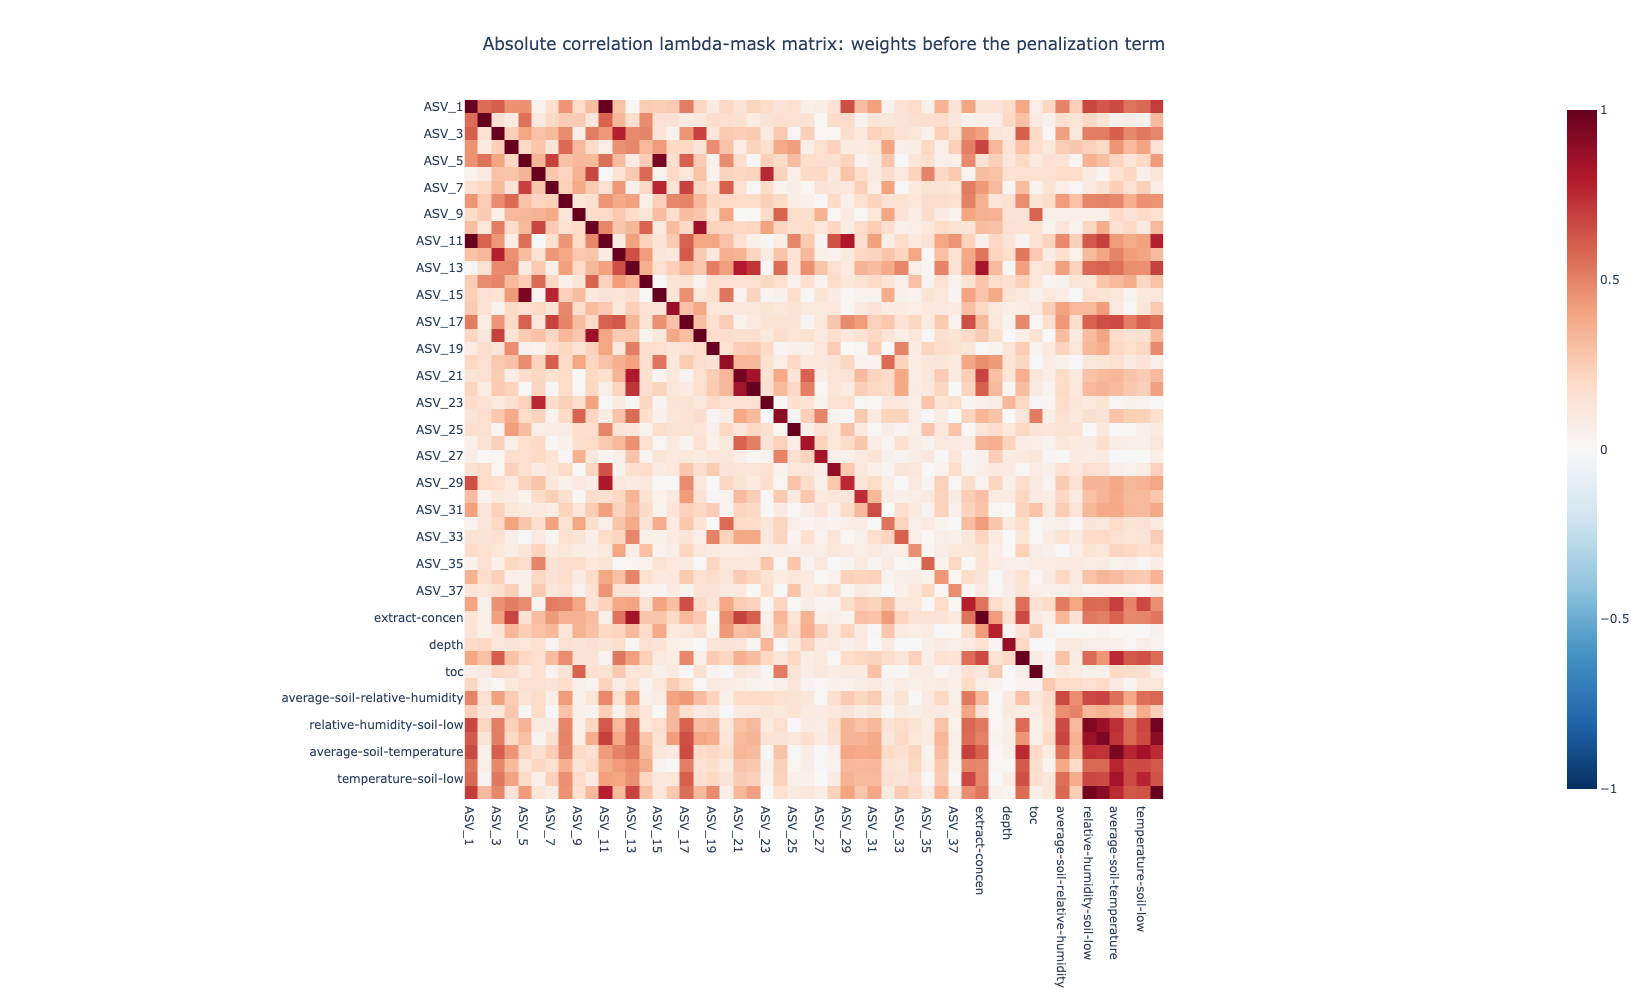

In [146]:
fig = px.imshow(df_mask_corr, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Absolute correlation lambda-mask matrix: weights before the penalization term', title_x=0.5)

# fig.write_image("../plots/png/lambda_mask_corr.png")
# fig.write_html("../plots/html/lambda_mask_corr.html")

In [147]:
lambda1_range = np.logspace(0, -2, 8)
mu1_range = np.logspace(1.5, 0, 6)

In [148]:
P_corr = glasso_problem(S.values, N, latent=True, do_scaling=False)
print(P_corr)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [ ]:
modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range, 'lambda1_mask': lambda1_mask_corr}

P_corr.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)
print(P_corr.reg_params)

ADMM terminated after 65 iterations with status: optimal.
ADMM terminated after 66 iterations with status: optimal.
ADMM terminated after 58 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 57 iterations with status: optimal.
ADMM terminated after 62 iterations with status: optimal.
ADMM terminated after 86 iterations with status: optimal.
ADMM terminated after 69 iterations with status: optimal.
ADMM terminated after 62 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 58 iterations with status: optimal.
ADMM terminated after 62 iterations with status: optimal.
ADMM terminated after 92 iterations with status: optimal.
ADMM terminated after 81 iterations with status: optimal.
ADMM terminated after 81 iterations with status: optimal.
ADMM terminated after 60 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminate

In [118]:
print(P_corr.modelselect_stats)

{'BIC': {0.1: array([[2720.8302885 , 2720.83029246, 2739.30573274, 2810.13518153,
        3014.63455656, 3534.21787097],
       [2661.02378715, 2661.0283714 , 2689.26699044, 2789.90397166,
        3022.10747347, 3534.21787163],
       [2616.70089719, 2616.72467845, 2616.72470476, 2622.35987267,
        2836.73791983, 3502.14340066],
       [2993.08804458, 2993.00999338, 2993.00402444, 2993.00290361,
        2927.18350245, 3172.27023657],
       [3502.76910261, 3502.68224032, 3502.64990533, 3502.63489626,
        3502.62718487, 3503.47535753],
       [3900.7951682 , 3900.70164867, 3900.65565788, 3900.62118196,
        3900.59757175, 3900.57855474],
       [4388.86396393, 4388.80266749, 4388.76498797, 4388.7365719 ,
        4388.71154173, 4388.69095583],
       [4840.74353516, 4840.09315081, 4840.03544997, 4840.00192467,
        4839.97573435, 4839.95355722]]), 0.5: array([[ 2727.15227845,  2727.15228241,  2745.62772269,  2810.13518153,
         3014.63455656,  3534.21787097],
       [ 3

In [119]:
Theta_corr = P_corr.solution.precision_

### SGL mask explicit

In [120]:
# create lambda matrix full of zeros
shape_meta = (p, p)
mask = np.zeros(shape_meta)

# add small constant, so ADMM could converge
mask = mask + 0.01

# heavy penalize species
n_bugs = len(bug_ticks)
bugs_block = np.ones((n_bugs, n_bugs))
mask[0:n_bugs, 0:n_bugs] += bugs_block - 0.01
lambda1_mask_exp = mask

NameError: name 'bug_ticks' is not defined

In [177]:
df_mask_exp = pd.DataFrame(lambda1_mask_exp, columns=vis_df.columns, index=S.index)

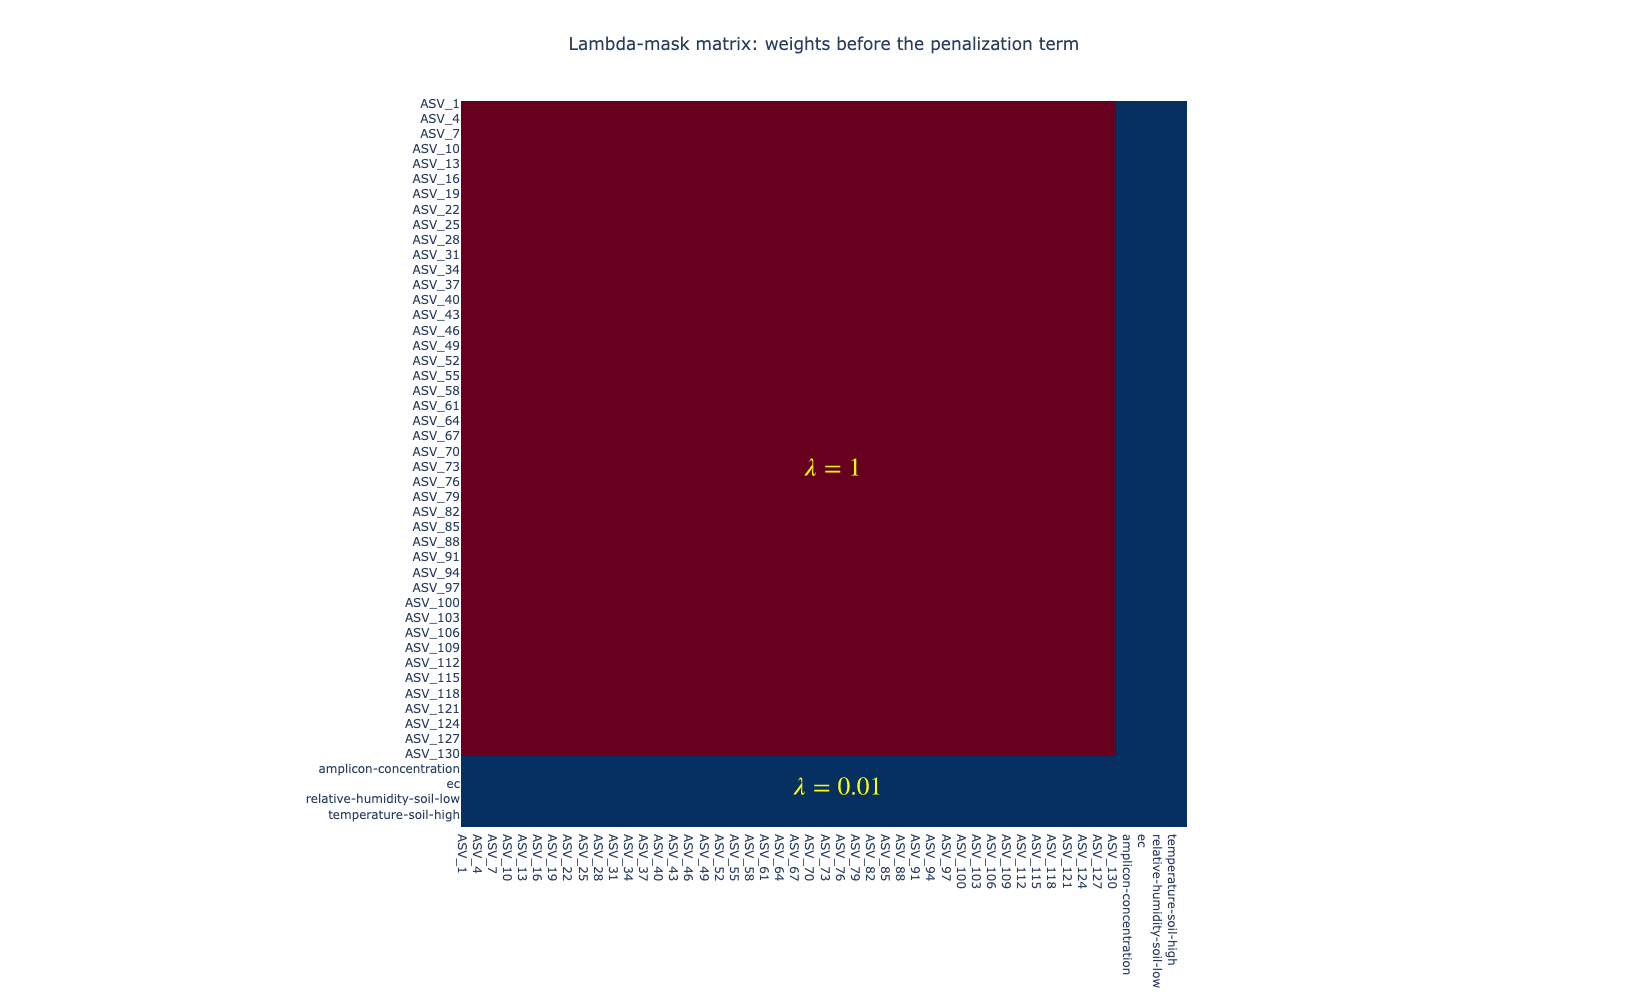

In [178]:
fig = px.imshow(df_mask_exp, color_continuous_scale='RdBu_r')
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Lambda-mask matrix: weights before the penalization term', title_x=0.5)

fig.add_annotation(text="$\lambda=1$",
                  xref="paper", yref="paper", font=dict(color='yellow',size=155),
                  x=0.5, y=0.5, showarrow=False)
fig.add_annotation(text="$\lambda=0.01$",
                  xref="paper", yref="paper", font=dict(color='yellow',size=155),
                  x=0.5, y=0.05, showarrow=False)

fig.update_coloraxes(showscale=False)

# fig.write_image("../plots/png/lambda_mask.png")
# fig.write_html("../plots/html/lambda_mask.html")

In [179]:
P_exp = glasso_problem(S.values, N, latent=True, do_scaling=False)
print(P_exp)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [180]:
lambda1_range = np.logspace(0, -2, 8)
mu1_range = np.logspace(1.5, 0, 6)

modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range, 'lambda1_mask': lambda1_mask_exp}

In [181]:
P_exp.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)

print(P_exp.reg_params)

ADMM terminated after 61 iterations with status: optimal.
ADMM terminated after 118 iterations with status: optimal.
ADMM terminated after 166 iterations with status: optimal.
ADMM terminated after 406 iterations with status: optimal.
ADMM terminated after 580 iterations with status: optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 130 iterations with status: optimal.
ADMM terminated after 118 iterations with status: optimal.
ADMM terminated after 166 iterations with status: optimal.
ADMM terminated after 406 iterations with status: optimal.
ADMM terminated after 580 iterations with status: optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 279 iterations with status: optimal.
ADMM terminated after 112 iterations with status: optimal.
ADMM terminated after 168 iterations with status: optimal.
ADMM terminated after 414 iterations with status: optimal.
ADMM terminated after 583 iterations with

LinAlgError: Eigenvalues did not converge

In [82]:
print(P_exp.modelselect_stats)

{'BIC': {0.1: array([[ 8.77018553e+03,  1.36376900e+04,  2.19087681e+04,
         3.65491551e+04,  6.90866940e+04,  2.24166143e+05],
       [ 8.74753712e+03,  1.36150135e+04,  2.19087662e+04,
         3.65571465e+04,  6.90867048e+04,  2.24166160e+05],
       [ 8.87537016e+03,  1.35360048e+04,  2.18054506e+04,
         3.69169002e+04,  6.92964056e+04,  2.24145887e+05],
       [ 4.35666513e+03,  4.35747961e+03,  2.30161248e+04,
         4.26011961e+04,  8.53008163e+04,  2.54358902e+05],
       [            inf,             inf, -6.98893403e+05,
        -8.57769918e+05,  1.71528025e+06,  4.83577350e+06],
       [            inf, -1.06553680e+08, -9.30609367e+08,
        -6.37705474e+09, -3.78246019e+10, -3.75055123e+10],
       [-3.79562134e+10,             inf, -3.87477950e+10,
        -3.94685157e+10, -4.04620913e+10, -4.13627688e+10],
       [-4.24284520e+10, -4.39121325e+10, -4.55982387e+10,
        -4.82975225e+10, -5.08312641e+10, -5.34836907e+10]]), 0.5: array([[ 8.77018553e+03,  1

In [83]:
Theta_exp = P_exp.solution.precision_
L = P_exp.solution.lowrank_

### no low_rank exp - optimal

In [84]:
P_exp_no = glasso_problem(S.values, N, latent=False, do_scaling=False)
print(P_exp_no)

modelselect_params = {'lambda1_range': lambda1_range, 'lambda1_mask': lambda1_mask_exp}

P_exp_no.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)

print(P_exp_no.reg_params)

Theta_exp_no = P_exp_no.solution.precision_

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': None, 'mu1': None}
ADMM terminated after 123 iterations with status: optimal.
ADMM terminated after 175 iterations with status: optimal.
ADMM terminated after 230 iterations with status: optimal.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: primal optimal.
{'lambda1': 0.01, 'mu1': 0}


In [86]:
print(P_exp_no.modelselect_stats)

{'BIC': {0.1: array([[ 5.76000000e+03],
       [ 1.44874899e+04],
       [ 8.87536119e+03],
       [ 4.36674056e+03],
       [            inf],
       [-3.82143110e+07],
       [-1.14110424e+08],
       [-6.66509278e+08]]), 0.5: array([[ 5.76000000e+03],
       [ 3.69192392e+04],
       [ 2.81820919e+04],
       [ 2.46435788e+04],
       [            inf],
       [-3.81868220e+07],
       [-1.14060638e+08],
       [-6.66445099e+08]]), 0.3: array([[ 5.76000000e+03],
       [ 2.57033646e+04],
       [ 1.85287265e+04],
       [ 1.45051597e+04],
       [            inf],
       [-3.82005665e+07],
       [-1.14085531e+08],
       [-6.66477189e+08]]), 0.25: array([[ 5.76000000e+03],
       [ 2.28993959e+04],
       [ 1.61153852e+04],
       [ 1.19705549e+04],
       [            inf],
       [-3.82040026e+07],
       [-1.14091754e+08],
       [-6.66485211e+08]]), 0.7: array([[ 5.76000000e+03],
       [ 4.81351139e+04],
       [ 3.78354572e+04],
       [ 3.47819979e+04],
       [            i

### no low_abs

In [88]:
P_abs_no = glasso_problem(S.values, N, latent=False, do_scaling=False)
print(P_exp_no)

modelselect_params = {'lambda1_range': lambda1_range, 'lambda1_mask': lambda1_mask_corr}

P_abs_no.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)

print(P_abs_no.reg_params)
Theta_corr_no = P_abs_no.solution.precision_

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.01, 'mu1': 0}
ADMM terminated after 123 iterations with status: optimal.
ADMM terminated after 175 iterations with status: optimal.
ADMM terminated after 230 iterations with status: optimal.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: primal optimal.
{'lambda1': 0.01, 'mu1': 0}


In [182]:
print(P_abs_no.modelselect_stats)

NameError: name 'P_abs_no' is not defined

### Save plots

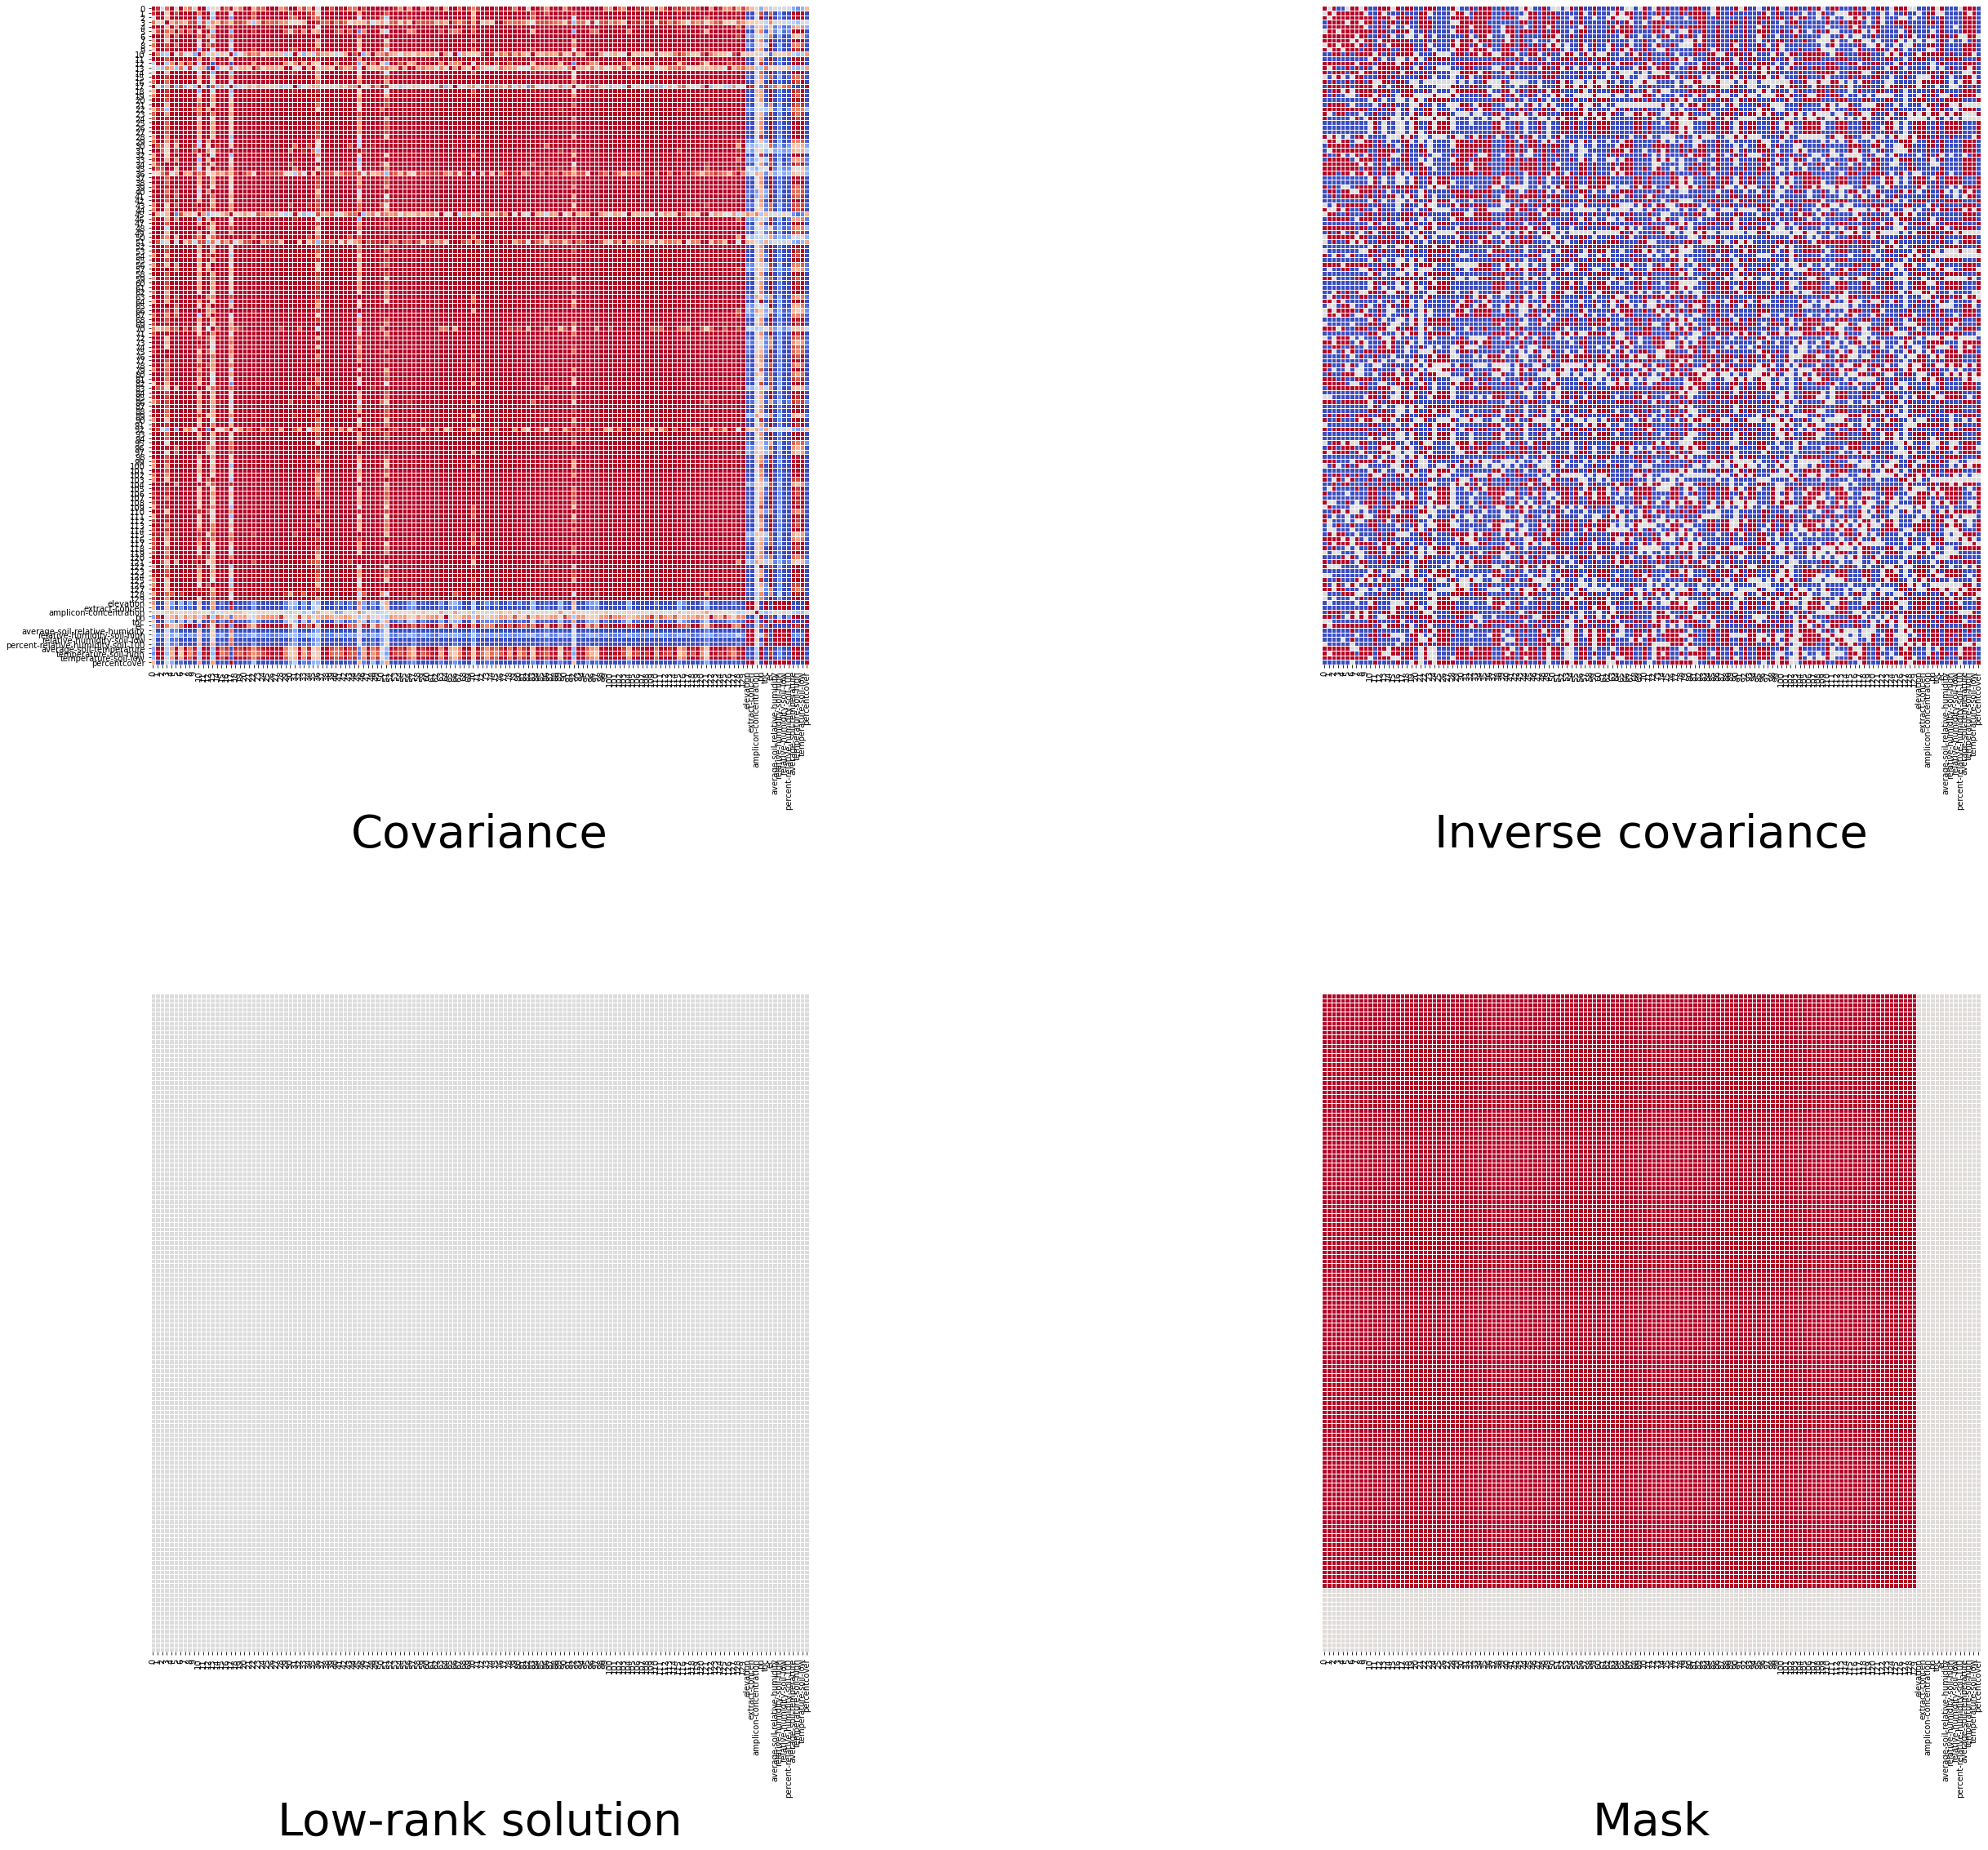

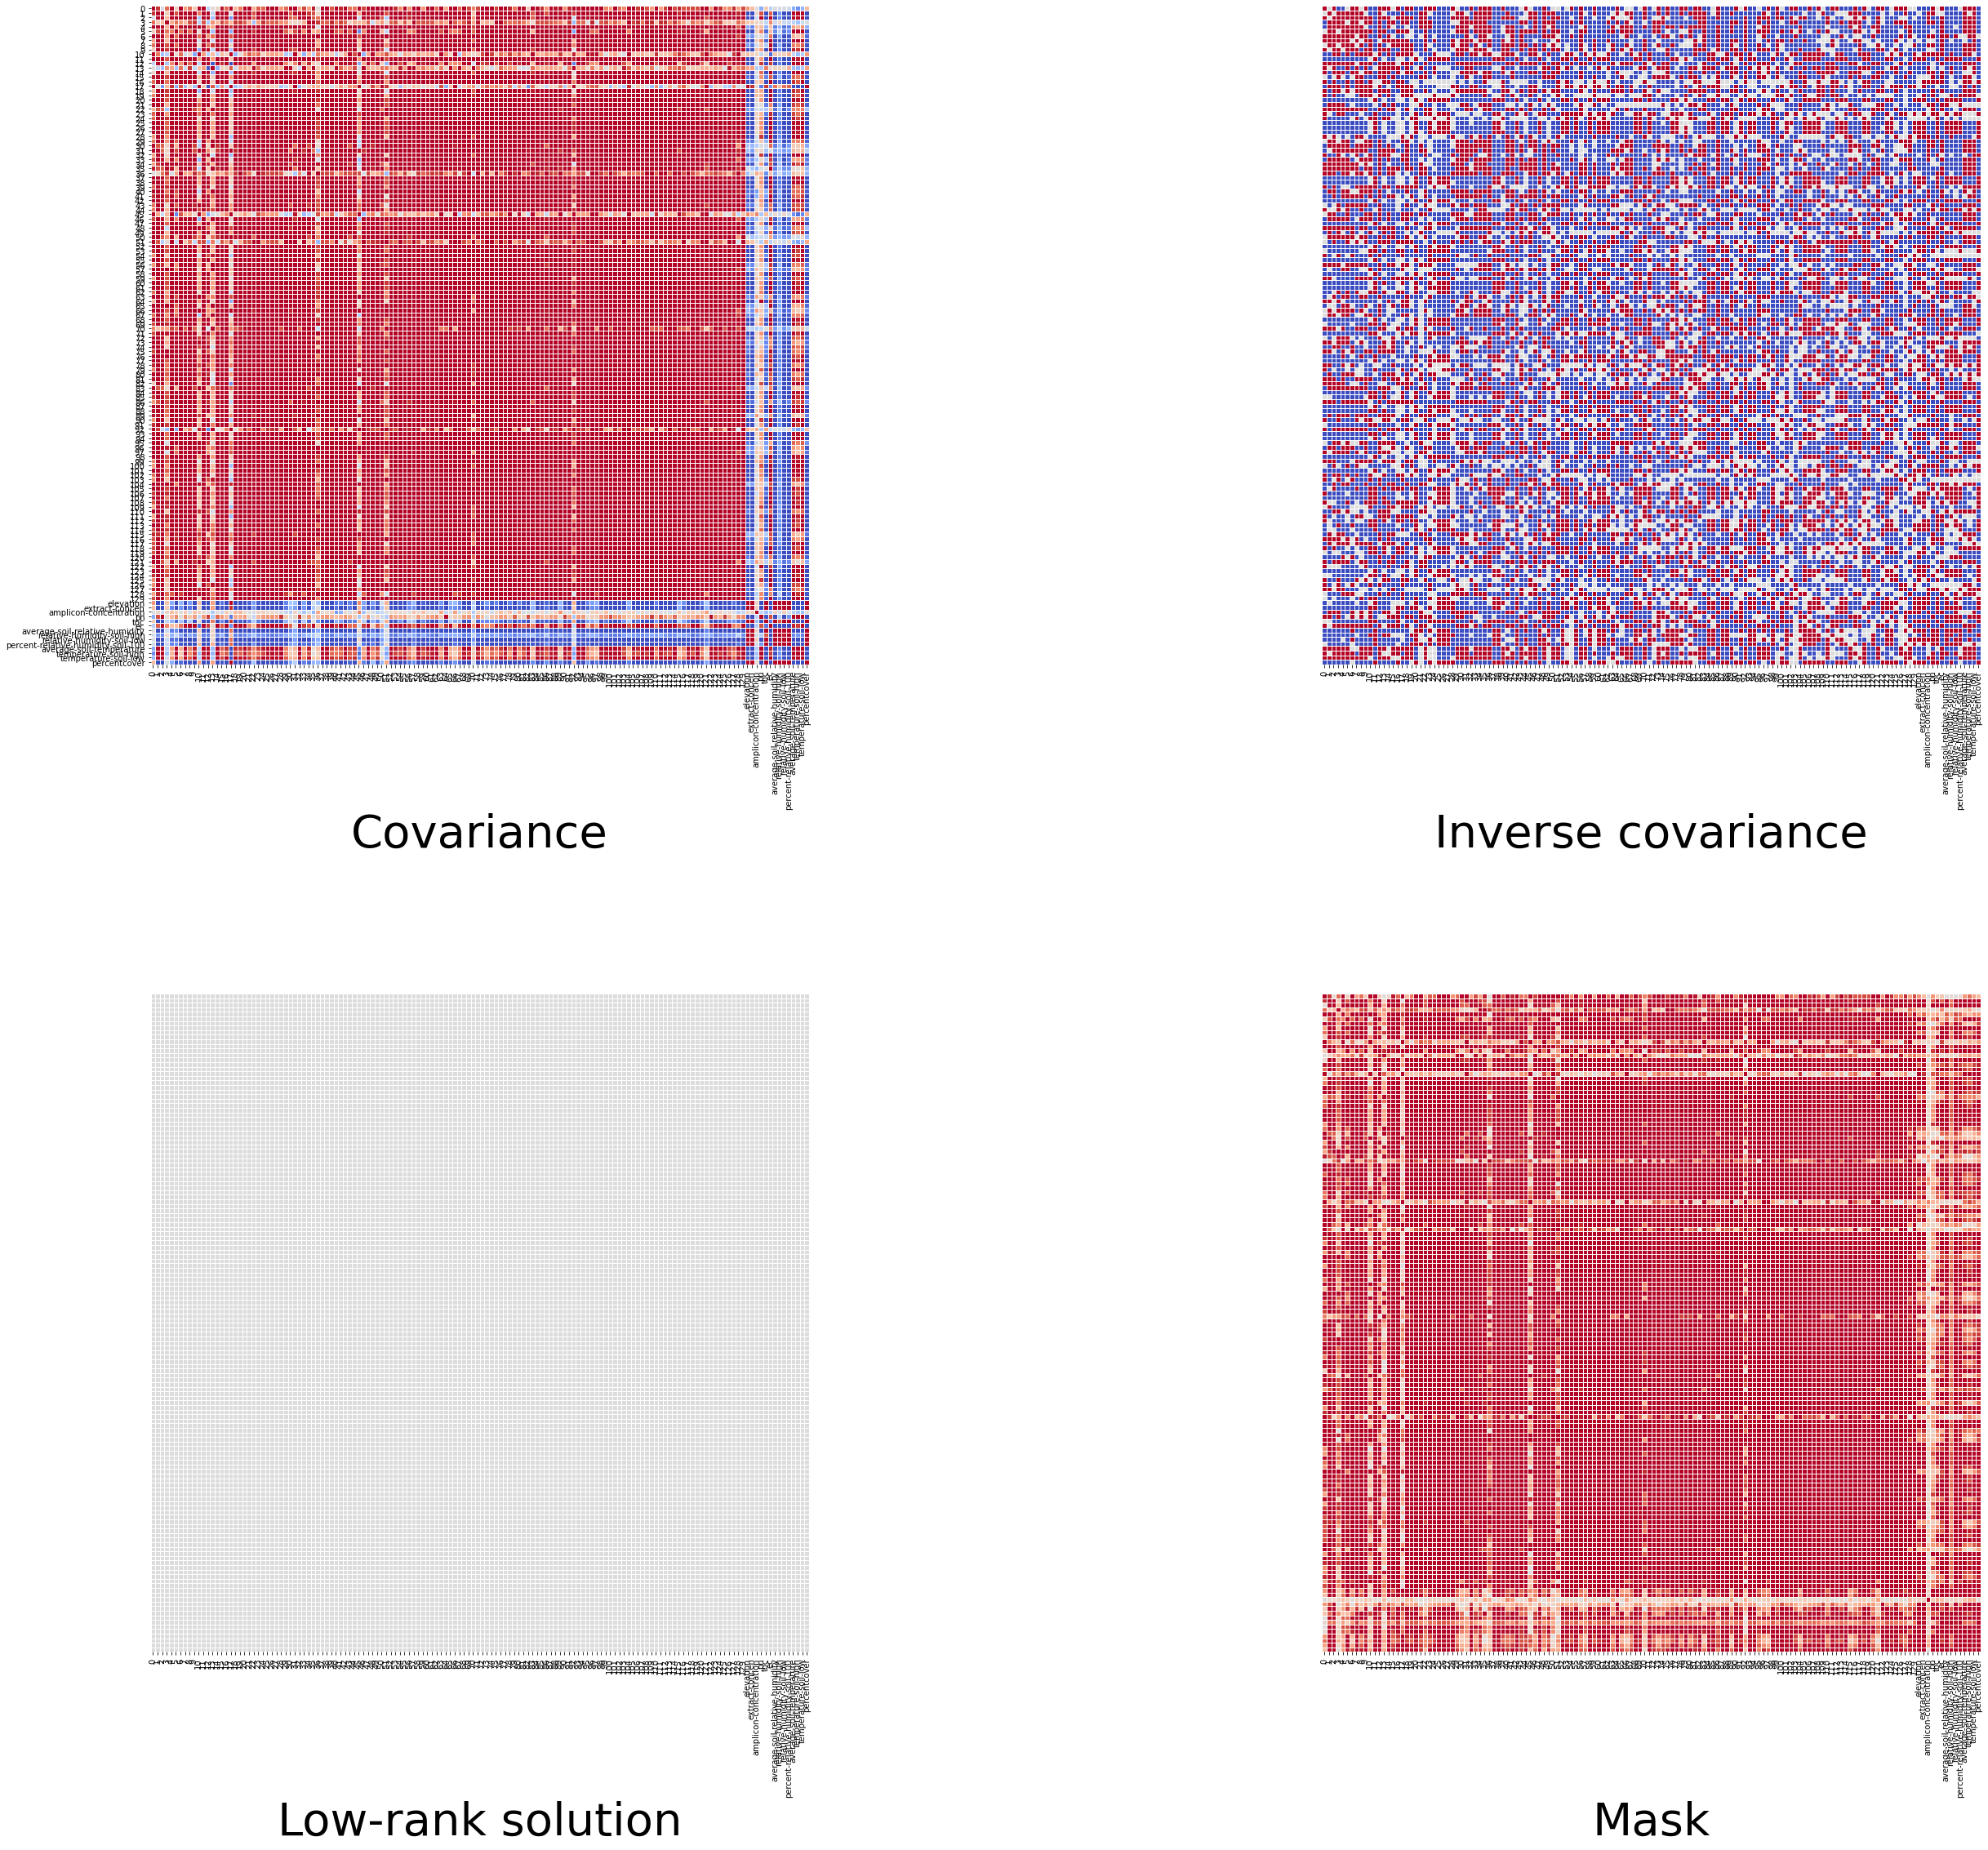

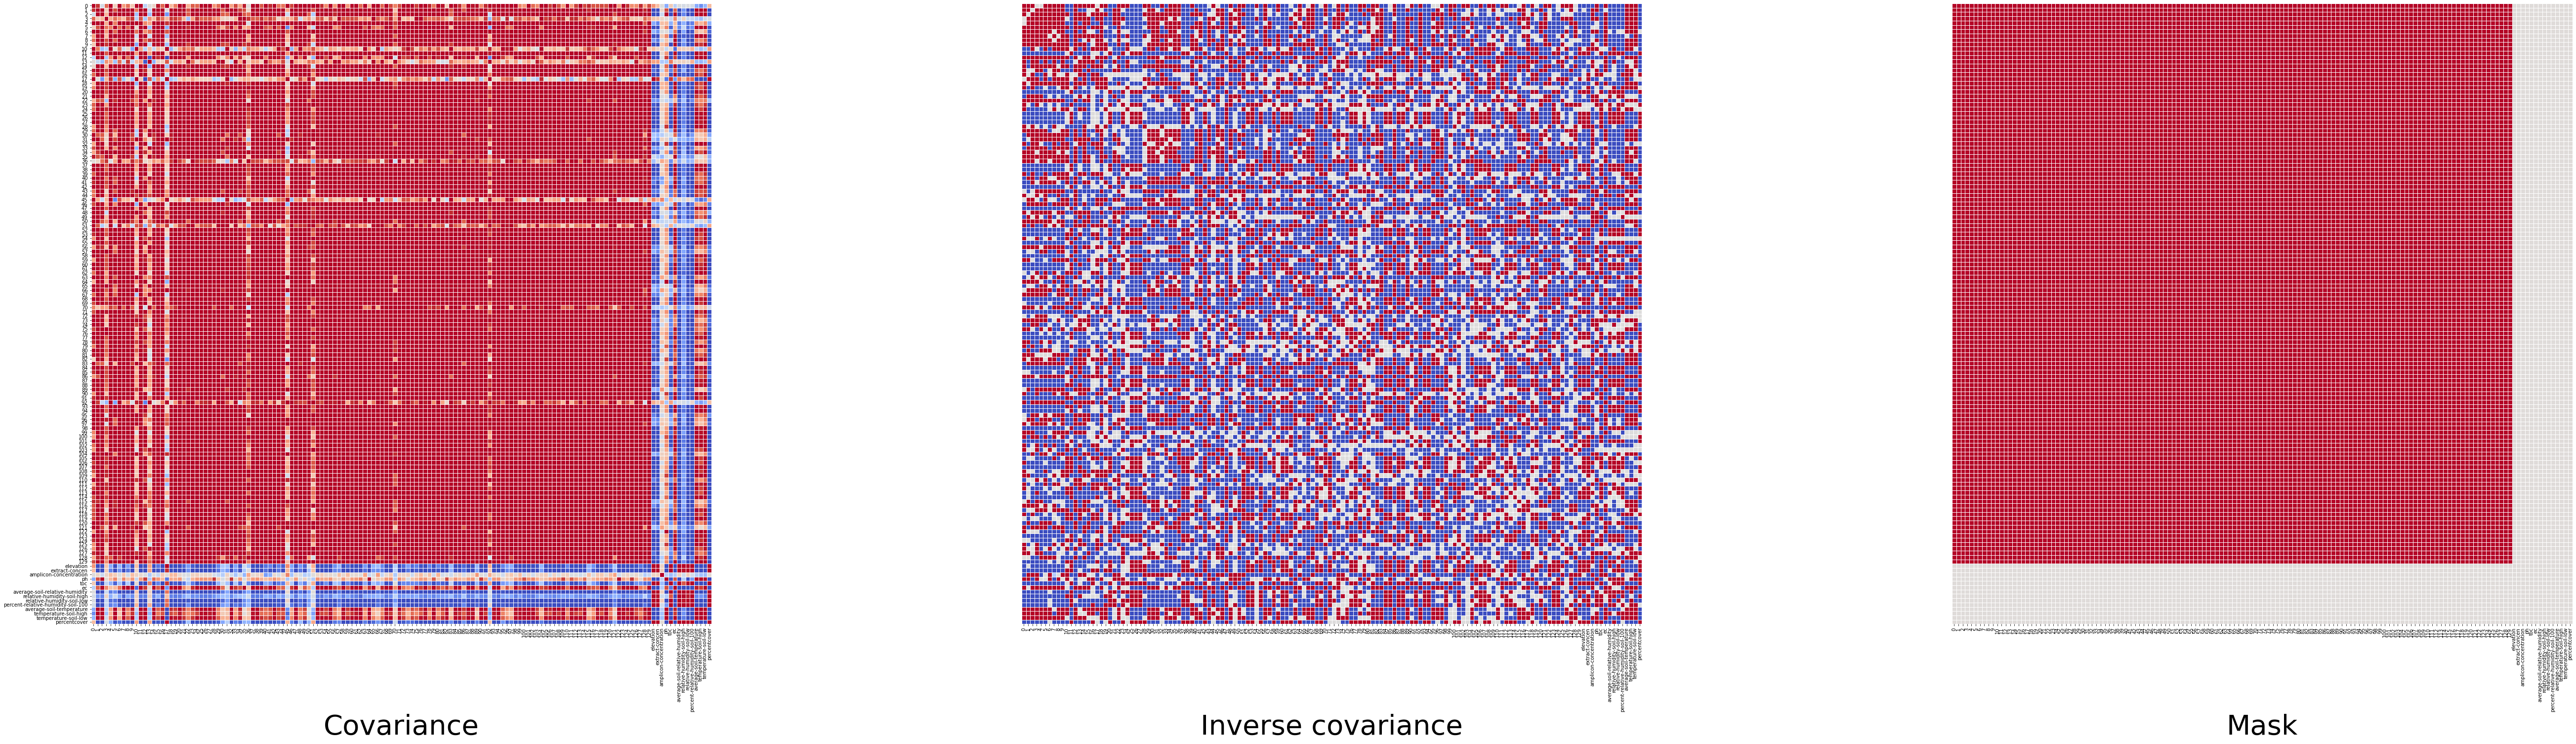

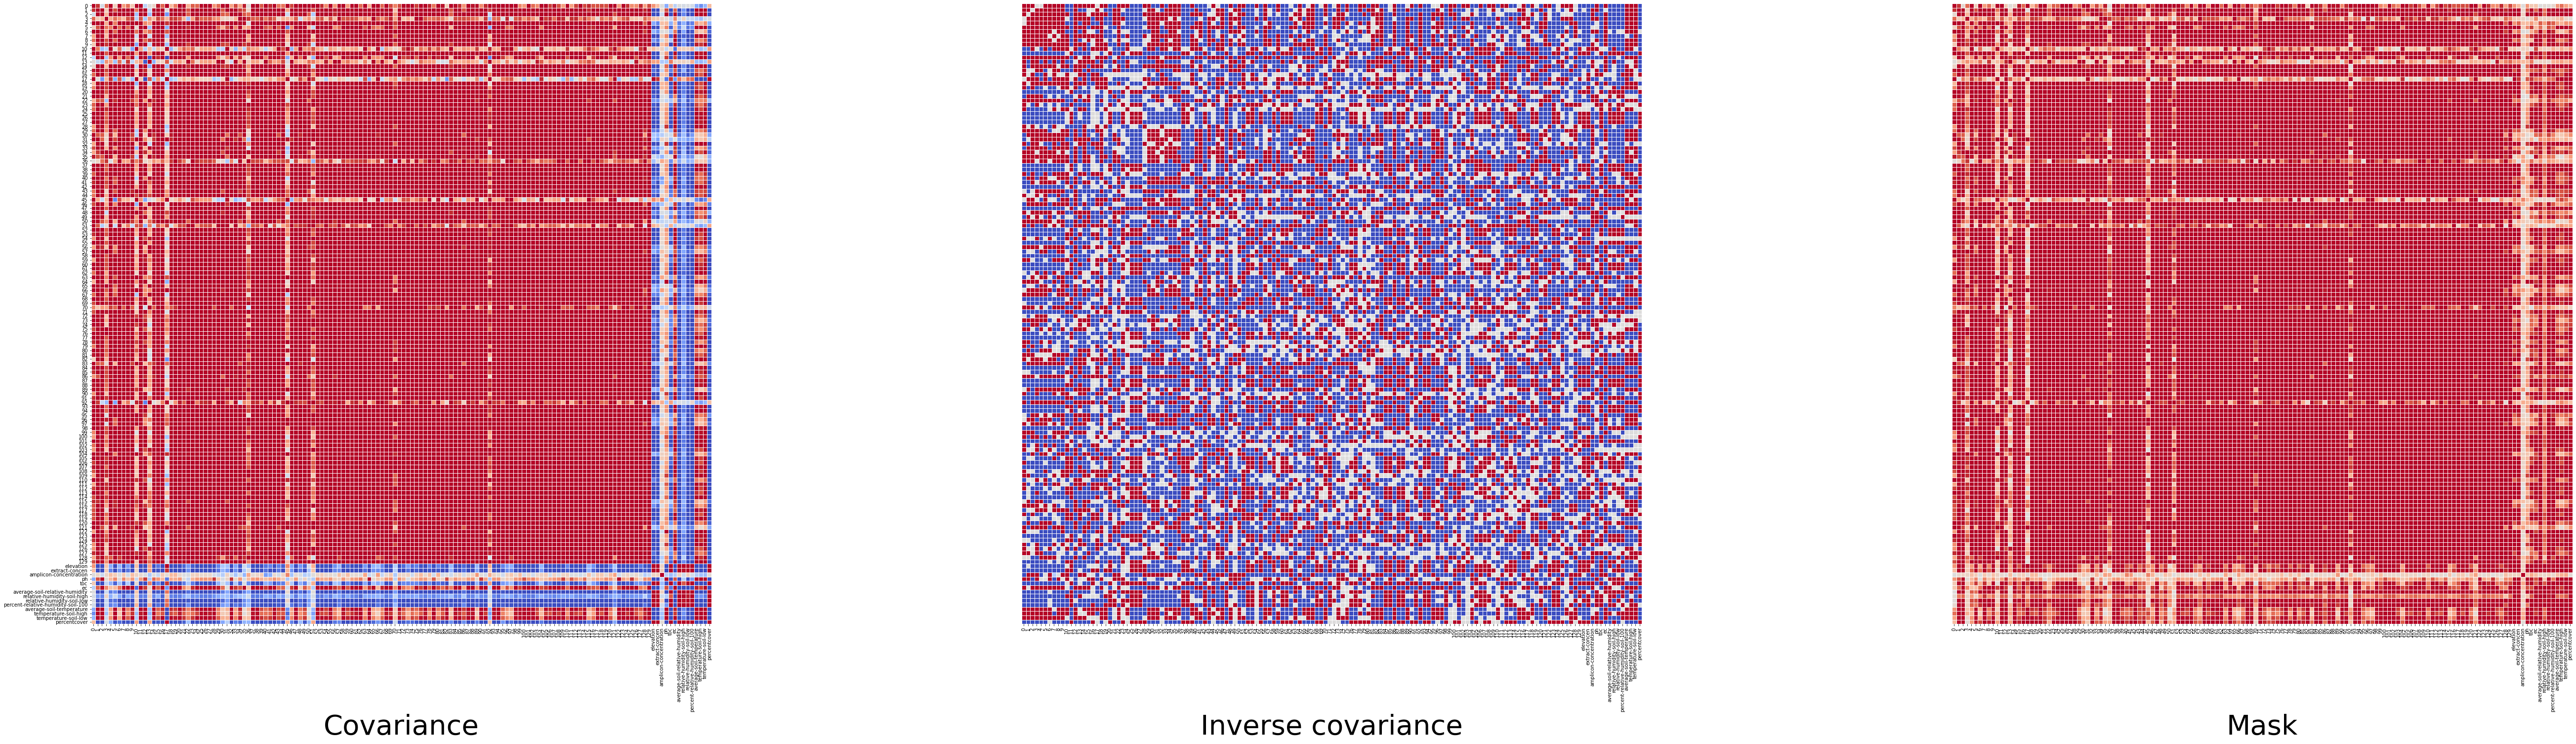

In [96]:
fig = plot_heatmap(cov=S, precision=Theta_exp, low_rank=L, mask=mask, low=True)
fig.savefig("../plots/png/low_rank_exp.png")

fig = plot_heatmap(cov=S, precision=Theta_corr, low_rank=L, mask=abs(S.values), low=True)
fig.savefig("../plots/png/low_rank_abscorr.png")


fig = plot_heatmap(cov=S, precision=Theta_exp_no, mask=mask, low=False)
fig.savefig("../plots/png/exp_no.png")

fig = plot_heatmap(cov=S, precision=Theta_corr_no, mask=abs(S.values), low=False)
fig.savefig("../plots/png/abscorr_no.png")